In [1]:
# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# Graph Creation
import ast
import networkx as nx

import torch

from sklearn.model_selection import train_test_split

# NLP
from transformers import BartTokenizer, BartModel
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import RobertaTokenizer, RobertaModel

from pyclustertend import vat, ivat

# sklearn
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

# Other
import warnings, sys, os, random, math
from tqdm import tqdm
import textwrap

sys.path.append(os.path.abspath('package'))

from package.hierarchical_graph import HierarchicalGraphBuilder, CallGraphBuilder
from package.code_normalizer import CodeNormalizer


# SETTINGS
pd.set_option('display.max_columns', 70)
warnings.filterwarnings("ignore")

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Semantic graph (KG Building)

## Prep

In [3]:
cg_nodes = pd.read_csv('graph/manim/cg_nodes.csv')
cg_edges = pd.read_csv('graph/manim/cg_edges.csv')
sg_nodes = pd.read_csv('graph/manim/sg_nodes.csv')
sg_edges = pd.read_csv('graph/manim/sg_edges.csv')
hier_1 = pd.read_csv('graph/manim/hier_1.csv')
hier_2 = pd.read_csv('graph/manim/hier_2.csv')

In [4]:
cg_nodes['docstring_embedding'] = cg_nodes['docstring_embedding'].apply(ast.literal_eval)
cg_nodes['wo_docstring_code'] = cg_nodes['function_code'].apply(CodeNormalizer().remove_docstring)
cg_nodes['norm_code'] = cg_nodes['function_code'].apply(CodeNormalizer().normalize)
cg_nodes = cg_nodes.loc[cg_nodes['docstring'].notna()]

In [5]:
cg_nodes["docstring"]

0       When giving a value by console, show an initia...
1       Same as :func:`show_splash`, but also exit whe...
4       Begin the animation.\n\nThis method is called ...
5       Finish the animation.\n\nThis method gets call...
6       Clean up the :class:`~.Scene` after finishing ...
                              ...                        
1358    Process the config options present in CLI argu...
1359    Process the config options present in a ``.cfg...
1391    The setter of the renderer property.\n\nTakes ...
1412    Template used when rendering Tex.  See :class:...
1413    Context manager that temporarily modifies the ...
Name: docstring, Length: 663, dtype: object

In [6]:
# Load CodeBERT
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)  # Move model to GPU if available
model.eval()  # Set model to evaluation mode

# Function to generate embeddings
def get_codebert_embedding(code_snippet):
    """
    Generate a CodeBERT embedding for a code snippet.
    Returns the mean pooled embedding as a list.
    """
    tokens = tokenizer(code_snippet, truncation=True, max_length=255, return_tensors="pt")['input_ids']
    tokens = torch.cat([tokens, torch.tensor([[tokenizer.eos_token_id]], device=tokens.device)], dim=1)
    tokens = tokens.to(device)  # Move tokens to GPU if available

    with torch.no_grad():
        outputs = model(tokens)[0][0]

    seq_len, hidden_size = outputs.shape
    if seq_len < 256:
        pad_len = 256 - seq_len
        padding = torch.zeros((pad_len, hidden_size), device=outputs.device)
        outputs = torch.cat([outputs, padding], dim=0)
    elif seq_len > 256:
        outputs = outputs[:256]

    return outputs.cpu().numpy().flatten()

# Apply to the dataframe
cg_nodes["docstring_CB_embedding"] = cg_nodes["docstring"].apply(get_codebert_embedding)

In [7]:
cg_nodes

combinedName  \
0                       show_splash   
1            print_version_and_exit   
4                   Animation.begin   
5                  Animation.finish   
6     Animation.clean_up_from_scene   
...                             ...   
1358        ManimConfig.digest_args   
1359        ManimConfig.digest_file   
1391           ManimConfig.renderer   
1412       ManimConfig.tex_template   
1413                     tempconfig   

                                          function_code  \
0     def show_splash(ctx: click.Context, param: cli...   
1     def print_version_and_exit(ctx: click.Context,...   
4     def begin(self) -> None:\n    """Begin the ani...   
5     def finish(self) -> None:\n    """Finish the a...   
6     def clean_up_from_scene(self, scene: Scene) ->...   
...                                                 ...   
1358  def digest_args(self, args: argparse.Namespace...   
1359  def digest_file(self, filename: StrPath) -> Se...   
1391  @renderer.setter\ndef renderer(self, value: st...   
1412  @property\ndef tex_template(self) -> TexTempla...   
1413  @contextmanager\ndef tempconfig(temp: ManimCon...   

                                              docstring  \
0     When giving a value by console, show an initia...   
1     Same as :func:`show_splash`, but also exit whe...   
4     Begin the animation.\n\nThis method is called ...   
5     Finish the animation.\n\nThis method gets call...   
6     Clean up the :class:`~.Scene` after finishing ...   
...                                                 ...   
1358  Process the config options present in CLI argu...   
1359  Process the config options present in a ``.cfg...   
1391  The setter of the renderer property.\n\nTakes ...   
1412  Template used when rendering Tex.  See :class:...   
1413  Context manager that temporarily modifies the ...   

                                    docstring_embedding  func_id  \
0     [0.04961501806974411, 0.03033692203462124, -0....        0   
1     [0.017242757603526115, 0.034651197493076324, -...        1   
4     [-0.023804470896720886, -0.042486000806093216,...        4   
5     [0.010196167044341564, -0.0007069521816447377,...        5   
6     [0.0009353216155432165, 0.025818094611167908, ...        6   
...                                                 ...      ...   
1358  [-0.02353455312550068, 0.031034868210554123, -...     1358   
1359  [-0.056435465812683105, 0.008449645712971687, ...     1359   
1391  [-0.0629633441567421, 0.023227617144584656, 0....     1391   
1412  [-0.07564476132392883, 0.11539892107248306, -0...     1412   
1413  [-0.012804128229618073, 0.057353291660547256, ...     1413   

                                      wo_docstring_code  \
0     def show_splash(ctx: click.Context, param: cli...   
1     def print_version_and_exit(ctx: click.Context,...   
4     def begin(self) -> None:\n    self.starting_mo...   
5     def finish(self) -> None:\n    self.interpolat...   
6     def clean_up_from_scene(self, scene: Scene) ->...   
...                                                 ...   
1358  def digest_args(self, args: argparse.Namespace...   
1359  def digest_file(self, filename: StrPath) -> Se...   
1391  @renderer.setter\ndef renderer(self, value: st...   
1412  @property\ndef tex_template(self) -> TexTempla...   
1413  @contextmanager\ndef tempconfig(temp: ManimCon...   

                                              norm_code  \
0     def FUNC_0(ARG_0: click.Context, ARG_1: click....   
1     def FUNC_0(ARG_0: click.Context, ARG_1: click....   
4     def FUNC_0(self) -> None:\n    self.CLASS_ATTR...   
5     def FUNC_0(self) -> None:\n    self.CLASS_FUNC...   
6     def FUNC_0(self, ARG_1: Scene) -> None:\n    s...   
...                                                 ...   
1358  def FUNC_0(self, ARG_1: argparse.Namespace) ->...   
1359  def FUNC_0(self, ARG_1: StrPath) -> Self:\n   ...   
1391  @VAR_2.setter\ndef FUNC_0(self, ARG_1: str | R...   
1412  @property\ndef

In [8]:
#cg_nodes.to_csv('graph/sklearn/cg_nodes_with_docstring_embeddings.csv', index=False)

## Data

In [6]:
cg_nodes = pd.read_csv('graph/manim/cg_nodes.csv')
cg_edges = pd.read_csv('graph/manim/cg_edges.csv')
sg_nodes = pd.read_csv('graph/manim/sg_nodes.csv')
sg_edges = pd.read_csv('graph/manim/sg_edges.csv')
hier_1 = pd.read_csv('graph/manim/hier_1.csv')
hier_2 = pd.read_csv('graph/manim/hier_2.csv')

In [7]:
cg_nodes.head()

combinedName  \
0                           clone   
1             _clone_parametrized   
2  BaseEstimator._get_param_names   
3        BaseEstimator.get_params   
4  BaseEstimator._get_params_html   

                                       function_code  \
0  def clone(estimator, *, safe=True):\n    """Co...   
1  def _clone_parametrized(estimator, *, safe=Tru...   
2  @classmethod\ndef _get_param_names(cls):\n    ...   
3  def get_params(self, deep=True):\n    """\n   ...   
4  def _get_params_html(self, deep=True):\n    ""...   

                                           docstring  \
0  Construct a new unfitted estimator with the sa...   
1  Default implementation of clone. See :func:`sk...   
2              Get parameter names for the estimator   
3  Get parameters for this estimator.\n\nParamete...   
4  Get parameters for this estimator with a speci...   

                                 docstring_embedding  func_id  \
0  [-0.13635297119617462, -0.10193724930286407, 0...        0   
1  [-0.12790191173553467, -0.0752759575843811, -0...        1   
2  [-0.005924790631979704, -0.017579255625605583,...        2   
3  [-0.0028749655466526747, -0.020313695073127747...        3   
4  [-0.03902079910039902, -0.03539375588297844, -...        4   

                                   wo_docstring_code  \
0  def clone(estimator, *, safe=True):\n    if ha...   
1  def _clone_parametrized(estimator, *, safe=Tru...   
2  @classmethod\ndef _get_param_names(cls):\n    ...   
3  def get_params(self, deep=True):\n    out = di...   
4  def _get_params_html(self, deep=True):\n    ou...   

                                           norm_code  \
0  def FUNC_0(ARG_0, *, safe=True):\n    if hasat...   
1  def FUNC_0(ARG_0, *, safe=True):\n    VAR_1 = ...   
2  @classmethod\ndef FUNC_0(ARG_0):\n    VAR_1 = ...   
3  def FUNC_0(self, ARG_1=True):\n    VAR_2 = dic...   
4  def FUNC_0(self, ARG_1=True):\n    VAR_2 = sel...   

                                  codebert_embedding  
0  [-0.1017985, 0.08984641, -0.007899207, 0.17950...  
1  [-0.19052112, -0.02253832, -0.06405669, 0.2956...  
2  [-0.096118994, 0.083859496, -0.08920947, 0.296...  
3  [-0.22579244, 0.045145426, -0.10750947, 0.2476...  
4  [-0.16866389, -0.008441396, -0.105790086, 0.31...

## Docstring similarity


In [7]:
docstring_mx = cg_nodes.loc[cg_nodes['docstring'].notna() & cg_nodes['docstring_embedding'].notna()].reset_index(drop=True)
#docstring_mx = cg_nodes.copy()
docstring_mx.head()

combinedName  \
0                    show_splash   
1         print_version_and_exit   
2                Animation.begin   
3               Animation.finish   
4  Animation.clean_up_from_scene   

                                       function_code  \
0  def show_splash(ctx: click.Context, param: cli...   
1  def print_version_and_exit(ctx: click.Context,...   
2  def begin(self) -> None:\n    """Begin the ani...   
3  def finish(self) -> None:\n    """Finish the a...   
4  def clean_up_from_scene(self, scene: Scene) ->...   

                                           docstring  \
0  When giving a value by console, show an initia...   
1  Same as :func:`show_splash`, but also exit whe...   
2  Begin the animation.\n\nThis method is called ...   
3  Finish the animation.\n\nThis method gets call...   
4  Clean up the :class:`~.Scene` after finishing ...   

                                 docstring_embedding  func_id  
0  [0.04961501806974411, 0.03033692203462124, -0....        0  
1  [0.017242757603526115, 0.034651197493076324, -...        1  
2  [-0.023804470896720886, -0.042486000806093216,...        4  
3  [0.010196167044341564, -0.0007069521816447377,...        5  
4  [0.0009353216155432165, 0.025818094611167908, ...        6

---
### Docstring embedding (whole)

In [ ]:
X = np.vstack(docstring_mx['docstring_CB_embedding'].apply(ast.literal_eval).to_numpy())

In [46]:
X = np.vstack(docstring_mx['docstring_CB_embedding'].to_numpy())

In [47]:
# L2 normalize rows
norms = np.linalg.norm(X, axis=1, keepdims=True)
Xn = X / np.clip(norms, 1e-12, None)

# Cosine similarity matrix
S = Xn @ Xn.T

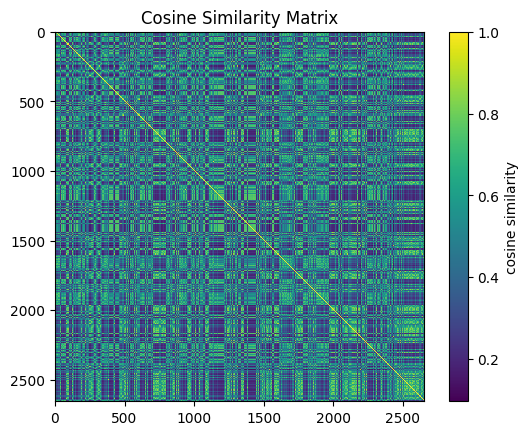

In [48]:
import matplotlib.pyplot as plt

plt.imshow(S, interpolation="nearest", cmap="viridis")
plt.colorbar(label="cosine similarity")
plt.title("Cosine Similarity Matrix")
plt.show()


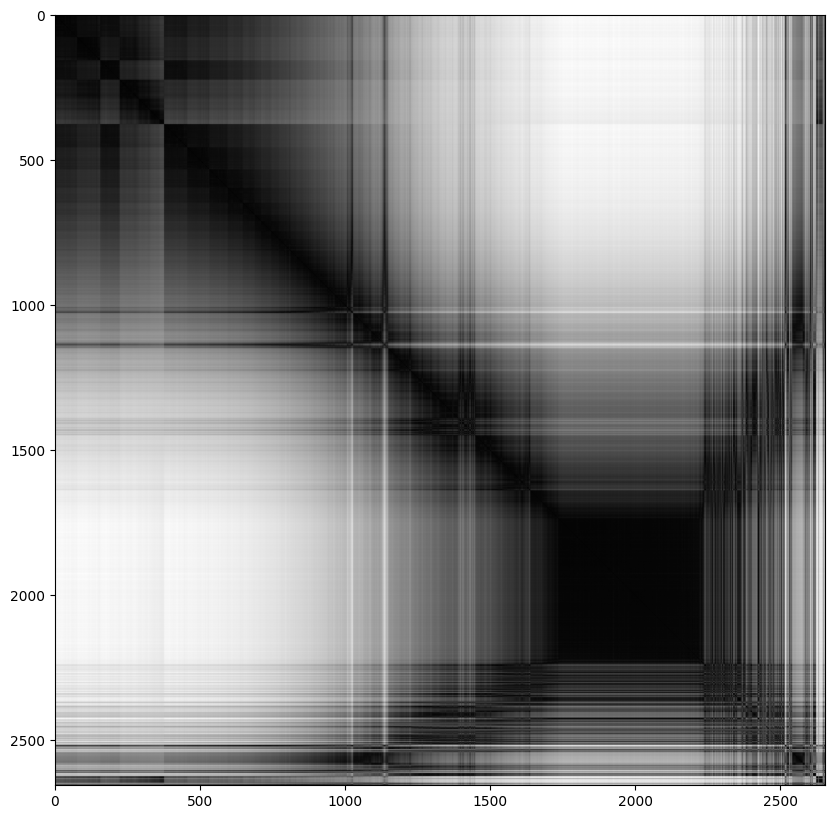

In [49]:
odm, ordering = vat(S, return_odm=True)

In [50]:
ordering

array([1082, 1997, 1998, ..., 1762,  863,    1])

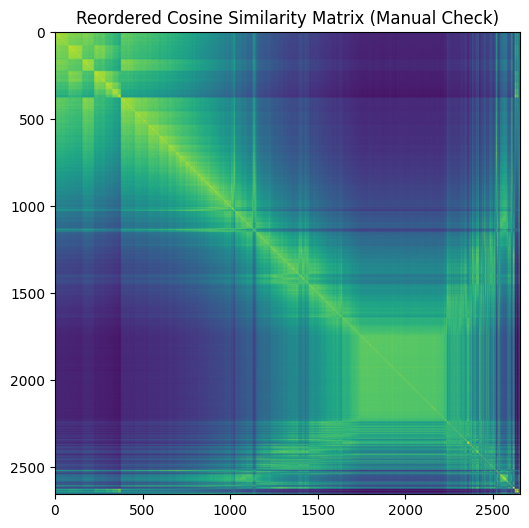

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# A: eredeti similarity mátrix (shape: [N, N])
# new_order: lista vagy array, ami megmondja, hogyan lett átrendezve

# Újrarendezett mátrix létrehozása
A_reordered = S[np.ix_(ordering, ordering)]

# Kirajzolás
plt.figure(figsize=(6, 6))
plt.imshow(A_reordered, cmap='viridis', aspect='auto')
plt.title("Reordered Cosine Similarity Matrix (Manual Check)")
plt.show()


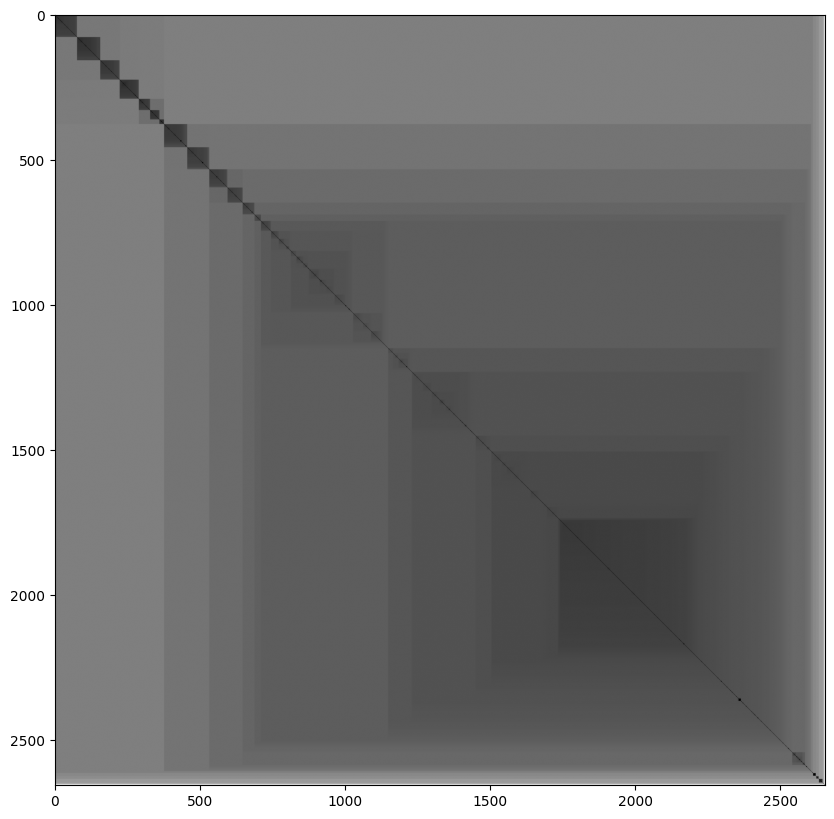

In [52]:
odm = ivat(S, return_odm=True)

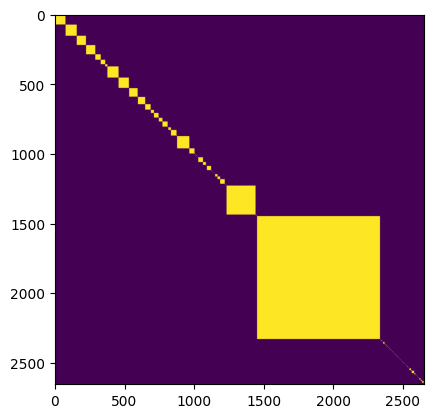

In [54]:
filtered_odm = odm < 0.575
plt.imshow(filtered_odm, cmap='viridis')

In [55]:
import numpy as np

def detect_clusters_from_binary_diagonal_matrix(binary_matrix: np.ndarray):
    """
    Detect clusters as contiguous square blocks of 1s along the diagonal
    of a binary matrix (usually thresholded iVAT result).

    Parameters
    ----------
    binary_matrix : np.ndarray
        A square binary matrix with 1s in diagonal blocks representing clusters.

    Returns
    -------
    clusters : list of tuples
        Each tuple is (start_index, end_index) for a detected cluster.
    """

    n = binary_matrix.shape[0]
    visited = np.zeros(n, dtype=bool)
    clusters = []

    i = 0
    while i < n:
        if visited[i]:
            i += 1
            continue

        # Start a potential cluster at i
        cluster_end = i
        while (
            cluster_end + 1 < n
            and binary_matrix[cluster_end, cluster_end + 1] == 1
            and binary_matrix[cluster_end + 1, cluster_end] == 1
        ):
            cluster_end += 1

        # Mark all indices in this cluster as visited
        visited[i : cluster_end + 1] = True
        clusters.append((i, cluster_end))

        i = cluster_end + 1

    return clusters

clusters = detect_clusters_from_binary_diagonal_matrix(filtered_odm)

for idx, (start, end) in enumerate(clusters):
    print(f"Cluster {idx + 1}: [{start} - {end}]")


Cluster 1: [0 - 74]
Cluster 2: [75 - 75]
Cluster 3: [76 - 155]
Cluster 4: [156 - 221]
Cluster 5: [222 - 222]
Cluster 6: [223 - 288]
Cluster 7: [289 - 327]
Cluster 8: [328 - 359]
Cluster 9: [360 - 375]
Cluster 10: [376 - 455]
Cluster 11: [456 - 529]
Cluster 12: [530 - 530]
Cluster 13: [531 - 531]
Cluster 14: [532 - 592]
Cluster 15: [593 - 593]
Cluster 16: [594 - 594]
Cluster 17: [595 - 646]
Cluster 18: [647 - 685]
Cluster 19: [686 - 686]
Cluster 20: [687 - 687]
Cluster 21: [688 - 709]
Cluster 22: [710 - 742]
Cluster 23: [743 - 744]
Cluster 24: [745 - 770]
Cluster 25: [771 - 807]
Cluster 26: [808 - 809]
Cluster 27: [810 - 811]
Cluster 28: [812 - 812]
Cluster 29: [813 - 831]
Cluster 30: [832 - 871]
Cluster 31: [872 - 875]
Cluster 32: [876 - 963]
Cluster 33: [964 - 1000]
Cluster 34: [1001 - 1003]
Cluster 35: [1004 - 1005]
Cluster 36: [1006 - 1006]
Cluster 37: [1007 - 1009]
Cluster 38: [1010 - 1010]
Cluster 39: [1011 - 1012]
Cluster 40: [1013 - 1015]
Cluster 41: [1016 - 1016]
Cluster 42: [1

In [56]:
docstring_mx['label'] = -1
cluster_number = 0

for cluster in clusters:
    if cluster[0] == cluster[1]:
        continue
    else:
        for row_idx in ordering[cluster[0]:cluster[1]]:
            docstring_mx.loc[row_idx, 'label'] = cluster_number
        cluster_number += 1

In [91]:
list(docstring_mx.loc[docstring_mx['label'] == 40]['combinedName'])

['_objective',
 'BaseGradientBoosting._fit_stages',
 'LinearClassifierMixin._predict_proba_lr',
 '_check_multi_class',
 'test_linear_regression_sample_weight_consistency',
 'test_lassolarsic_alpha_selection',
 'test_multimetric_scorer_exception_handling',
 'PredefinedSplit._split',
 '_is_pairwise_metric',
 'check_inplace_ensure_writeable',
 '_threadpool_controller_decorator',
 '_isin',
 '_get_counts',
 'make_constraint',
 '_message_with_time',
 'process_tempita']

---
Check similarity

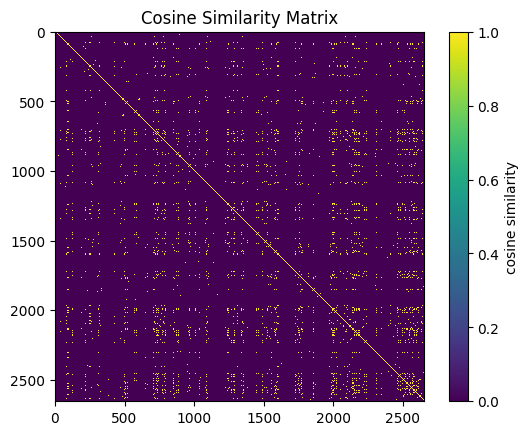

In [24]:
import matplotlib.pyplot as plt

plt.imshow(S > 0.8, interpolation="nearest", cmap="viridis")
plt.colorbar(label="cosine similarity")
plt.title("Cosine Similarity Matrix")
plt.show()


In [ ]:
import numpy as np

def get_high_similarity_pairs(S, threshold=0.65, include_diagonal=False):
    """
    Extract all (i, j, value) pairs from similarity matrix S
    where value >= threshold.
    """
    # Ensure S is a numpy array
    S = np.array(S)

    # Get indices where condition is met
    if include_diagonal:
        rows, cols = np.where(S >= threshold)
    else:
        # Use upper triangle only (avoid duplicates and diagonal)
        rows, cols = np.where(np.triu(S, k=1) >= threshold)

    values = S[rows, cols]
    return list(zip(rows, cols, values))


get_high_similarity_pairs(S, threshold=0.80, include_diagonal=False)

[(np.int64(3), np.int64(978), np.float64(0.8954808434477637)),
 (np.int64(8), np.int64(1392), np.float64(0.8566038619185306)),
 (np.int64(10), np.int64(290), np.float64(0.8048396602249257)),
 (np.int64(11), np.int64(12), np.float64(0.8118182213489995)),
 (np.int64(11), np.int64(13), np.float64(0.8087965730523162)),
 (np.int64(15), np.int64(16), np.float64(0.8062258694499601)),
 (np.int64(15), np.int64(143), np.float64(0.804482557638755)),
 (np.int64(15), np.int64(151), np.float64(0.8671456524373766)),
 (np.int64(15), np.int64(301), np.float64(0.9933551776366927)),
 (np.int64(15), np.int64(669), np.float64(0.9270547905683161)),
 (np.int64(15), np.int64(684), np.float64(0.835548206727351)),
 (np.int64(15), np.int64(688), np.float64(0.835548206727351)),
 (np.int64(15), np.int64(905), np.float64(0.835548206727351)),
 (np.int64(15), np.int64(915), np.float64(0.9113408405239787)),
 (np.int64(15), np.int64(1014), np.float64(0.9933551776366927)),
 (np.int64(15), np.int64(1020), np.float64(0.99

In [136]:
print(docstring_mx.iloc[15]['docstring'])

Get output feature names for transformation.

Parameters
----------
input_features : array-like of str or None, default=None
    Input features.

    - If `input_features` is `None`, then `feature_names_in_` is
      used as feature names in. If `feature_names_in_` is not defined,
      then the following input feature names are generated:
      `["x0", "x1", ..., "x(n_features_in_ - 1)"]`.
    - If `input_features` is an array-like, then `input_features` must
      match `feature_names_in_` if `feature_names_in_` is defined.

Returns
-------
feature_names_out : ndarray of str objects
    Same as input features.


In [137]:
print(docstring_mx.iloc[1020]['docstring'])

Get output feature names for transformation.

Parameters
----------
input_features : array-like of str or None, default=None
    Input features.

    - If `input_features` is `None`, then `feature_names_in_` is
      used as feature names in. If `feature_names_in_` is not defined,
      then the following input feature names are generated:
      `["x0", "x1", ..., "x(n_features_in_ - 1)"]`.
    - If `input_features` is an array-like, then `input_features` must
      match `feature_names_in_` if `feature_names_in_` is defined.

Returns
-------
feature_names_out : ndarray of str objects
    Transformed feature names.


---
### Token IoU (Jaccard index)

In [92]:
D = docstring_mx['docstring'].to_numpy()

In [93]:
from transformers import AutoTokenizer, AutoModel
import torch

# TinyBERT modell neve
model_name = "huawei-noah/TinyBERT_General_4L_312D"

# Tokenizer és modell betöltése
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the contents of D list
tokenized_docstrings = [tokenizer.tokenize(doc) for doc in D]

In [94]:
# Calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.
    Returns the Jaccard similarity score.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

def calculate_jaccard_matrix(tokenized_snippets):
    """
    Calculate the Jaccard similarity matrix for a list of tokenized code snippets.
    Returns a 2D numpy array representing the Jaccard similarity matrix.
    """
    n = len(tokenized_snippets)
    jaccard_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            set1 = set(tokenized_snippets[i])
            set2 = set(tokenized_snippets[j])
            similarity = jaccard_similarity(set1, set2)
            jaccard_matrix[i, j] = similarity
            jaccard_matrix[j, i] = similarity
    
    return jaccard_matrix

ds_jaccard_matrix = calculate_jaccard_matrix(tokenized_docstrings)

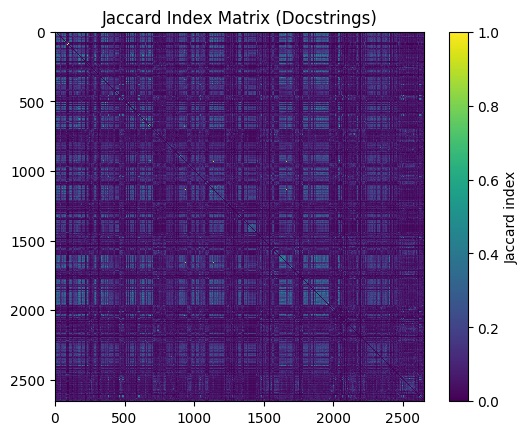

In [95]:
import matplotlib.pyplot as plt

plt.imshow(ds_jaccard_matrix, interpolation="nearest", cmap="viridis")
plt.colorbar(label="Jaccard index")
plt.title("Jaccard Index Matrix (Docstrings)")
plt.show()

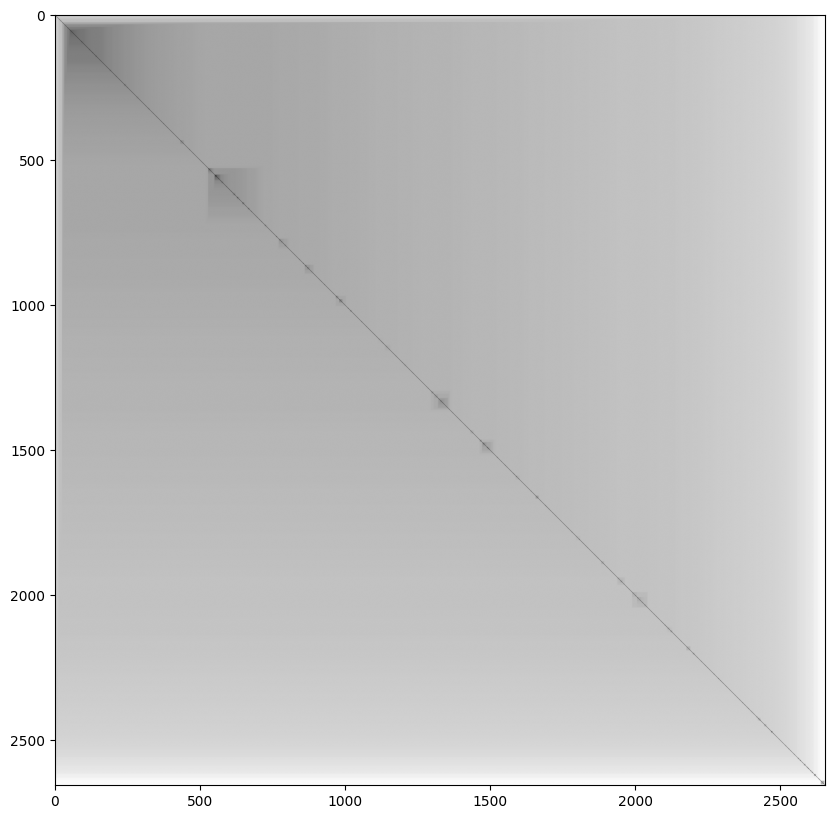

In [96]:
ivat(ds_jaccard_matrix)

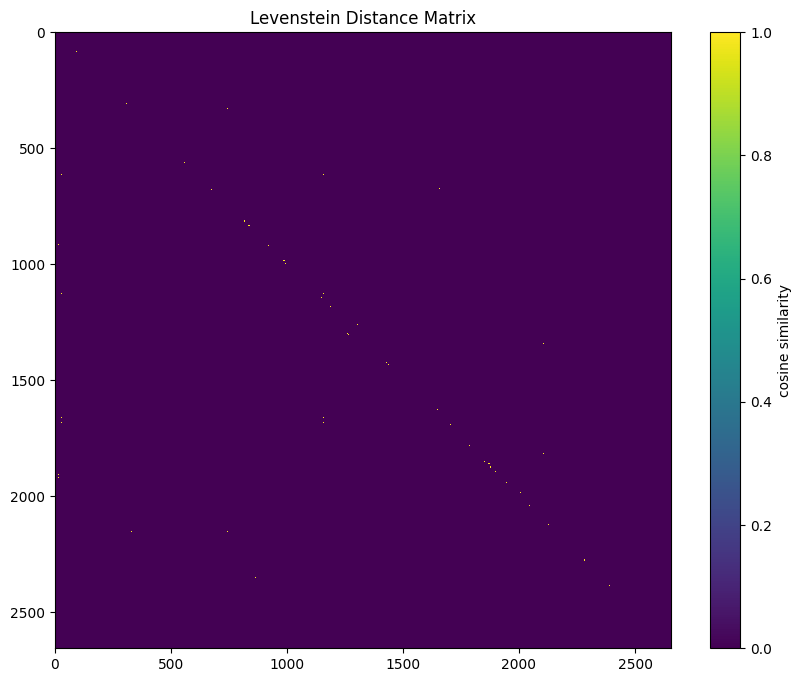

In [142]:
import matplotlib.pyplot as plt

DJ_TRESHOLD = 0.8

plt.figure(figsize=(10, 8))
plt.imshow(ds_jaccard_matrix > DJ_TRESHOLD, interpolation="nearest", cmap="viridis")
plt.colorbar(label="cosine similarity")
plt.title("Levenstein Distance Matrix")
plt.show()

In [143]:
import numpy as np


def find_values_above_threshold(matrix, threshold, exclude_diagonal=True):
    rows, cols = np.where(matrix > threshold)
    results = [(r, c, matrix[r, c]) for r, c in zip(rows, cols)]
    
    if exclude_diagonal:
        results = [(r, c, val) for r, c, val in results if r != c]
    
    return results

find_values_above_threshold(ds_jaccard_matrix, threshold=DJ_TRESHOLD)

[(np.int64(3), np.int64(978), np.float64(0.9534883720930233)),
 (np.int64(15), np.int64(301), np.float64(0.9642857142857143)),
 (np.int64(15), np.int64(915), np.float64(0.8333333333333334)),
 (np.int64(15), np.int64(1014), np.float64(0.9642857142857143)),
 (np.int64(15), np.int64(1020), np.float64(0.9642857142857143)),
 (np.int64(15), np.int64(1031), np.float64(0.9642857142857143)),
 (np.int64(15), np.int64(1035), np.float64(0.9642857142857143)),
 (np.int64(15), np.int64(1907), np.float64(0.9285714285714286)),
 (np.int64(15), np.int64(1920), np.float64(0.9642857142857143)),
 (np.int64(15), np.int64(1948), np.float64(0.9642857142857143)),
 (np.int64(15), np.int64(1952), np.float64(0.9642857142857143)),
 (np.int64(18), np.int64(19), np.float64(0.9807692307692307)),
 (np.int64(18), np.int64(20), np.float64(0.8947368421052632)),
 (np.int64(19), np.int64(18), np.float64(0.9807692307692307)),
 (np.int64(19), np.int64(20), np.float64(0.8793103448275862)),
 (np.int64(20), np.int64(18), np.floa

In [144]:
print(docstring_mx.iloc[27]['docstring'])

Get metadata routing of this object.

Please check :ref:`User Guide <metadata_routing>` on how the routing
mechanism works.

Returns
-------
routing : MetadataRouter
    A :class:`~sklearn.utils.metadata_routing.MetadataRouter` encapsulating
    routing information.


In [145]:
print(docstring_mx.iloc[936]['docstring'])

Get metadata routing of this object.

Please check :ref:`User Guide <metadata_routing>` on how the routing
mechanism works.

.. versionadded:: 1.6

Returns
-------
routing : MetadataRouter
    A :class:`~sklearn.utils.metadata_routing.MetadataRouter` encapsulating
    routing information.


---
### TF-IDF (Docstring)

In [8]:
test_df = pd.read_csv('graph/manim/cg_nodes.csv')
test_df = test_df[test_df['docstring'].notna()]
test_df

combinedName  \
0                       show_splash   
1            print_version_and_exit   
4                   Animation.begin   
5                  Animation.finish   
6     Animation.clean_up_from_scene   
...                             ...   
1358        ManimConfig.digest_args   
1359        ManimConfig.digest_file   
1391           ManimConfig.renderer   
1412       ManimConfig.tex_template   
1413                     tempconfig   

                                          function_code  \
0     def show_splash(ctx: click.Context, param: cli...   
1     def print_version_and_exit(ctx: click.Context,...   
4     def begin(self) -> None:\n    """Begin the ani...   
5     def finish(self) -> None:\n    """Finish the a...   
6     def clean_up_from_scene(self, scene: Scene) ->...   
...                                                 ...   
1358  def digest_args(self, args: argparse.Namespace...   
1359  def digest_file(self, filename: StrPath) -> Se...   
1391  @renderer.setter\ndef renderer(self, value: st...   
1412  @property\ndef tex_template(self) -> TexTempla...   
1413  @contextmanager\ndef tempconfig(temp: ManimCon...   

                                              docstring  \
0     When giving a value by console, show an initia...   
1     Same as :func:`show_splash`, but also exit whe...   
4     Begin the animation.\n\nThis method is called ...   
5     Finish the animation.\n\nThis method gets call...   
6     Clean up the :class:`~.Scene` after finishing ...   
...                                                 ...   
1358  Process the config options present in CLI argu...   
1359  Process the config options present in a ``.cfg...   
1391  The setter of the renderer property.\n\nTakes ...   
1412  Template used when rendering Tex.  See :class:...   
1413  Context manager that temporarily modifies the ...   

                                    docstring_embedding  func_id  
0     [0.04961501806974411, 0.03033692203462124, -0....        0  
1     [0.017242757603526115, 0.034651197493076324, -...        1  
4     [-0.023804470896720886, -0.042486000806093216,...        4  
5     [0.010196167044341564, -0.0007069521816447377,...        5  
6     [0.0009353216155432165, 0.025818094611167908, ...        6  
...                                                 ...      ...  
1358  [-0.02353455312550068, 0.031034868210554123, -...     1358  
1359  [-0.056435465812683105, 0.008449645712971687, ...     1359  
1391  [-0.0629633441567421, 0.023227617144584656, 0....     1391  
1412  [-0.07564476132392883, 0.11539892107248306, -0...     1412  
1413  [-0.012804128229618073, 0.057353291660547256, ...     1413  

[663 rows x 5 columns]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN

#D = docstring_mx['docstring'].to_numpy()
D = test_df['docstring'].to_numpy()

In [10]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(D)

<Axes: >

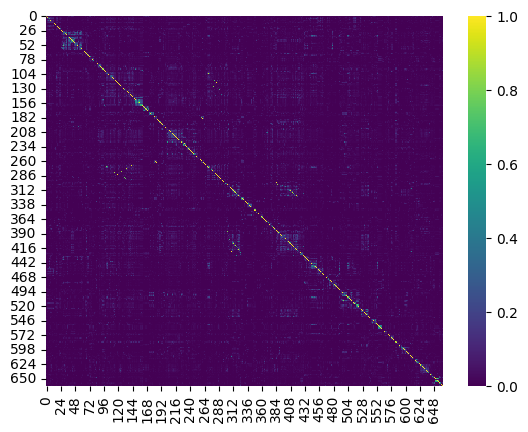

In [11]:
cosine_similarity_matrix = metrics.pairwise.cosine_similarity(X.toarray())
sns.heatmap(cosine_similarity_matrix, cmap='viridis')

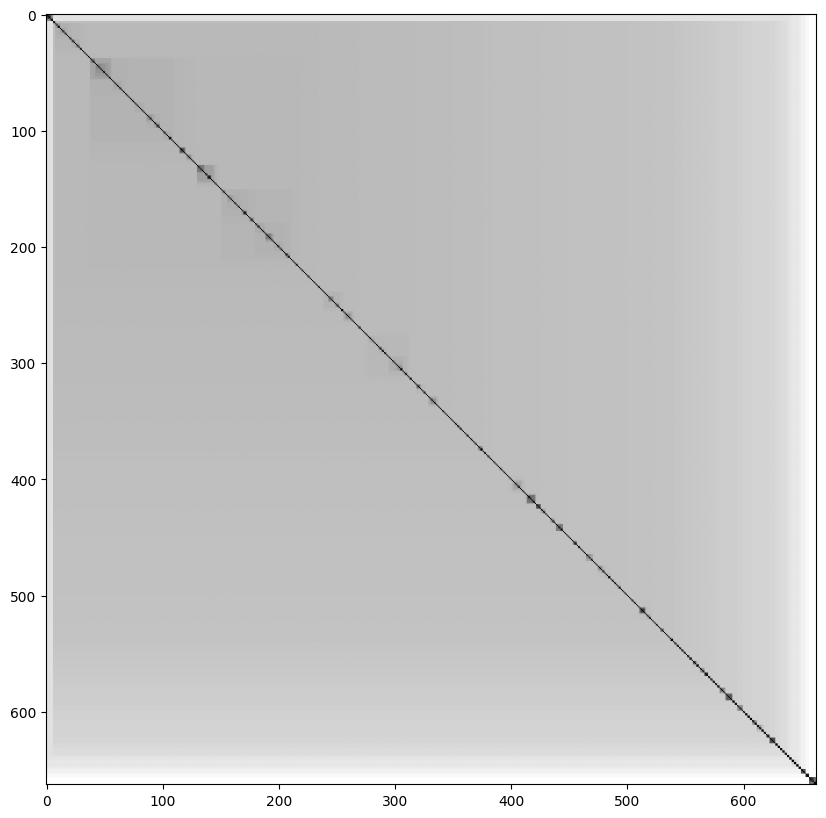

In [12]:
odm, ordering = ivat(cosine_similarity_matrix, return_odm=True)

In [13]:
filtered_odm = odm < 1.334

<Axes: >

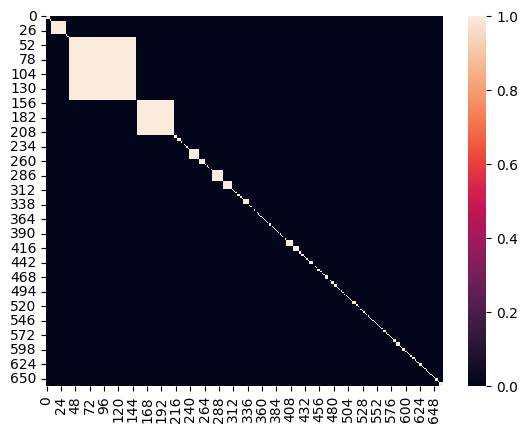

In [14]:
sns.heatmap(filtered_odm)

In [15]:
import numpy as np

def detect_clusters_from_binary_diagonal_matrix(binary_matrix: np.ndarray):
    """
    Detect clusters as contiguous square blocks of 1s along the diagonal
    of a binary matrix (usually thresholded iVAT result).

    Parameters
    ----------
    binary_matrix : np.ndarray
        A square binary matrix with 1s in diagonal blocks representing clusters.

    Returns
    -------
    clusters : list of tuples
        Each tuple is (start_index, end_index) for a detected cluster.
    """

    n = binary_matrix.shape[0]
    visited = np.zeros(n, dtype=bool)
    clusters = []

    i = 0
    while i < n:
        if visited[i]:
            i += 1
            continue

        # Start a potential cluster at i
        cluster_end = i
        while (
            cluster_end + 1 < n
            and binary_matrix[cluster_end, cluster_end + 1] == 1
            and binary_matrix[cluster_end + 1, cluster_end] == 1
        ):
            cluster_end += 1

        # Mark all indices in this cluster as visited
        visited[i : cluster_end + 1] = True
        clusters.append((i, cluster_end))

        i = cluster_end + 1

    return clusters

clusters = detect_clusters_from_binary_diagonal_matrix(filtered_odm)

for idx, (start, end) in enumerate(clusters):
    print(f"Cluster {idx + 1}: [{start} - {end}]")


Cluster 1: [0 - 5]
Cluster 2: [6 - 7]
Cluster 3: [8 - 32]
Cluster 4: [33 - 34]
Cluster 5: [35 - 37]
Cluster 6: [38 - 149]
Cluster 7: [150 - 150]
Cluster 8: [151 - 213]
Cluster 9: [214 - 217]
Cluster 10: [218 - 218]
Cluster 11: [219 - 224]
Cluster 12: [225 - 226]
Cluster 13: [227 - 227]
Cluster 14: [228 - 228]
Cluster 15: [229 - 229]
Cluster 16: [230 - 231]
Cluster 17: [232 - 232]
Cluster 18: [233 - 233]
Cluster 19: [234 - 236]
Cluster 20: [237 - 237]
Cluster 21: [238 - 238]
Cluster 22: [239 - 255]
Cluster 23: [256 - 264]
Cluster 24: [265 - 265]
Cluster 25: [266 - 266]
Cluster 26: [267 - 267]
Cluster 27: [268 - 270]
Cluster 28: [271 - 271]
Cluster 29: [272 - 272]
Cluster 30: [273 - 273]
Cluster 31: [274 - 274]
Cluster 32: [275 - 276]
Cluster 33: [277 - 294]
Cluster 34: [295 - 310]
Cluster 35: [311 - 311]
Cluster 36: [312 - 312]
Cluster 37: [313 - 314]
Cluster 38: [315 - 315]
Cluster 39: [316 - 317]
Cluster 40: [318 - 318]
Cluster 41: [319 - 322]
Cluster 42: [323 - 326]
Cluster 43: [327 

In [16]:
docstring_mx['label'] = -1
cluster_number = 0

for cluster in clusters:
    if cluster[0] == cluster[1]:
        continue
    else:
        for row_idx in ordering[cluster[0]:cluster[1]]:
            docstring_mx.loc[row_idx, 'label'] = cluster_number
        cluster_number += 1

In [17]:
cluster_number

110

In [26]:
list(docstring_mx.loc[docstring_mx['label'] == 6]['combinedName'])

['Mobject.shift',
 'VectorField.fit_to_coordinate_system',
 'VectorField.nudge',
 'VectorField.runge_kutta',
 'VectorField.nudge_submobjects',
 'VectorField.start_submobject_movement',
 'VectorField.stop_submobject_movement',
 'ArrowVectorField.get_vector',
 'Arrow.get_normal_vector',
 'Arrow.reset_normal_vector',
 'CoordinateSystem._get_axis_label',
 'CoordinateSystem.plot',
 'CoordinateSystem.plot_implicit_curve',
 'CoordinateSystem.plot_parametric_curve',
 'CoordinateSystem.plot_polar_graph',
 'CoordinateSystem.plot_surface',
 'CoordinateSystem.input_to_graph_point',
 'CoordinateSystem.get_graph_label',
 'CoordinateSystem.get_riemann_rectangles',
 'CoordinateSystem.get_area',
 'CoordinateSystem.angle_of_tangent',
 'CoordinateSystem.plot_derivative_graph',
 'CoordinateSystem.plot_antiderivative_graph',
 'CoordinateSystem.get_secant_slope_group',
 'CoordinateSystem.get_vertical_lines_to_graph',
 'CoordinateSystem.get_T_label',
 'Axes.coords_to_point',
 'Axes.point_to_coords',
 'ThreeD

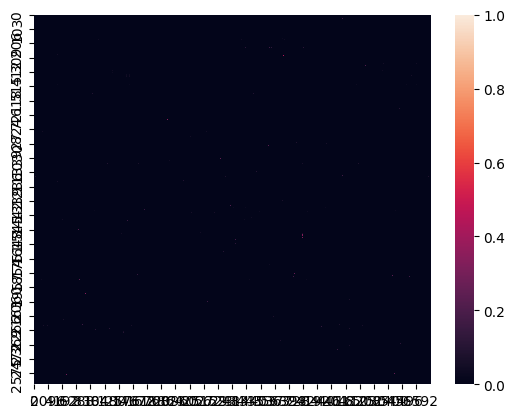

In [102]:
sns.heatmap(X.toarray())

In [80]:
pca = PCA(n_components=2000)
X_reduced = pca.fit_transform(X.toarray())

# Print overall explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Explained variance ratio: 0.9433827553909331


Silhouette score:  0.008141243976136785


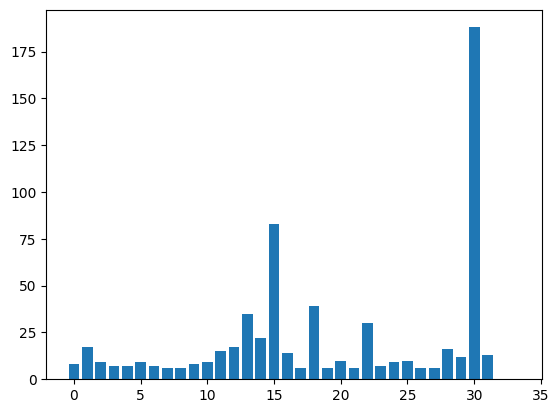

In [ ]:
km = HDBSCAN(min_cluster_size=6)
labels = km.fit_predict(X)

print('Silhouette score: ', metrics.silhouette_score(X, labels, metric='euclidean'))

plt.hist(labels, bins=np.arange(30) - 0.5, rwidth=0.8);

In [102]:
import string
from collections import Counter

def top_n_words(text_list, n=20, filter_common_array=None):
    words = []
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        words.extend(text.lower().split())

    # Filter common words
    if filter_common_array:
        words = [word for word in words if word not in filter_common_array]

    # Count the words
    word_counts = Counter(words)

    return word_counts.most_common(n)


res = pd.DataFrame({
    'docstring': D,
    'label': labels
})

#docstring_mx['label'] = labels
test_df['label'] = labels

res.head()

docstring  label
0  Construct a new unfitted estimator with the sa...     -1
1  Default implementation of clone. See :func:`sk...     -1
2              Get parameter names for the estimator     -1
3  Get parameters for this estimator.\n\nParamete...     28
4  Get parameters for this estimator with a speci...     28

In [103]:
common_list = [item for item, value in top_n_words(res['docstring'].to_list(), 45)]
common_list

['the',
 'of',
 'to',
 'is',
 'a',
 'for',
 'and',
 'shape',
 'nsamples',
 'in',
 'if',
 'x',
 'or',
 'be',
 '1',
 'parameters',
 'arraylike',
 'data',
 'returns',
 'that',
 'matrix',
 'nfeatures',
 'with',
 '0',
 'are',
 'ndarray',
 'y',
 'this',
 'array',
 'sparse',
 'number',
 'not',
 'from',
 'as',
 'none',
 'by',
 'values',
 'defaultnone',
 'each',
 'an',
 'on',
 'check',
 'used',
 'will',
 'samples']

In [112]:
list(test_df[test_df['label'] == 55]['combinedName'])

['test_mutual_reachability_graph_error_sparse_format',
 'test_partial_dependence_sample_weight_size_error',
 'test_linear_regression_sample_weight_consistency',
 'test_enet_sample_weight_consistency',
 'test_enet_cv_sample_weight_consistency',
 'test_ridge_sample_weight_consistency',
 'test_glm_sample_weight_consistency']

In [ ]:
list(docstring_mx[docstring_mx['label'] == 0]['combinedName'])

['MiniBatchKMeans._mini_batch_convergence',
 'test_labelling_distinct',
 '_check_fetch_lfw',
 'MiniBatchNMF._minibatch_convergence',
 '_create_expansion',
 '_validate_dual_parameter',
 '_with_config_and_warning_filters',
 'numerical_derivative']

In [370]:
top_n_words(res[res['label'] == 3]['docstring'].to_list(), n=20, filter_common_array=common_list)

[('true', 9),
 ('also', 9),
 ('return', 7),
 ('function', 7),
 ('does', 7),
 ('import', 7),
 ('it', 7),
 ('has', 7),
 ('already', 7),
 ('been', 7),
 ('imported', 7),
 ('therefore', 7),
 ('cheap', 7),
 ('use', 7),
 ('see', 7),
 ('arraynamespace', 7),
 ('isarrayapiobj', 7),
 ('iscupyarray', 6),
 ('isndonnxarray', 6),
 ('isdaskarray', 6)]

---
### IoU (Function name)

In [ ]:
test_df = pd.read_csv('graph/manim/cg_nodes.csv')
test_df = test_df[test_df['combinedName'].notna()]
test_df['combinedName'] = test_df['combinedName'].apply(lambda x: x.replace('.', ' ').replace('_', ' '))
test_df

combinedName  \
0                    show splash   
1         print version and exit   
2             Animation   init     
3     Animation  typecheck input   
4                Animation begin   
...                          ...   
1409  ManimConfig custom folders   
1410      ManimConfig input file   
1411     ManimConfig output file   
1412    ManimConfig tex template   
1413                  tempconfig   

                                          function_code  \
0     def show_splash(ctx: click.Context, param: cli...   
1     def print_version_and_exit(ctx: click.Context,...   
2     def __init__(self, mobject: Mobject | None, la...   
3     def _typecheck_input(self, mobject: Mobject | ...   
4     def begin(self) -> None:\n    """Begin the ani...   
...                                                 ...   
1409  @custom_folders.setter\ndef custom_folders(sel...   
1410  @input_file.setter\ndef input_file(self, value...   
1411  @output_file.setter\ndef output_file(self, val...   
1412  @property\ndef tex_template(self) -> TexTempla...   
1413  @contextmanager\ndef tempconfig(temp: ManimCon...   

                                              docstring  \
0     When giving a value by console, show an initia...   
1     Same as :func:`show_splash`, but also exit whe...   
2                                                   NaN   
3                                                   NaN   
4     Begin the animation.\n\nThis method is called ...   
...                                                 ...   
1409                                                NaN   
1410                                                NaN   
1411                                                NaN   
1412  Template used when rendering Tex.  See :class:...   
1413  Context manager that temporarily modifies the ...   

                                    docstring_embedding  func_id  
0     [0.04961501806974411, 0.03033692203462124, -0....        0  
1     [0.017242757603526115, 0.034651197493076324, -...        1  
2     [-0.11883845180273056, 0.0482986681163311, -0....        2  
3     [-0.11883839964866638, 0.04829868674278259, -0...        3  
4     [-0.023804470896720886, -0.042486000806093216,...        4  
...                                                 ...      ...  
1409  [-0.11883839964866638, 0.04829868674278259, -0...     1409  
1410  [-0.11883839964866638, 0.04829868674278259, -0...     1410  
1411  [-0.11883839964866638, 0.04829868674278259, -0...     1411  
1412  [-0.07564476132392883, 0.11539892107248306, -0...     1412  
1413  [-0.012804128229618073, 0.057353291660547256, ...     1413  

[1414 rows x 5 columns]

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.cluster import KMeans, HDBSCAN

#D = docstring_mx['docstring'].to_numpy()
D = test_df['combinedName'].to_numpy()

Silhouette score:  -0.2312647756850029


(array([460.,  16.,  23.,   5.,   3.,   6.,   3.,   6.,  39.,  18.,   5.,
          4.,   3.,   8.,   3.,   6.,  34.,   8.,   4.,   6.,   6.,   6.,
          6.,   9.,  16.,  16.,   6.,  16.,  16.,  15.,  17.,   3.,   7.,
         16.,  15.,   3.,   9.,  17.,   6.,   3.,   3.,  16.,  16.,   3.,
          4.,   9.,   3.,   5.,   4.,   4.,   3.,   5.,   5.,  10.,   3.,
          3.,   3.,  16.,  16.,   4.,  10.,   5.,   3.,  10.,   3.,  11.,
          5.,   6.,   8.,   3.,   3.,   3.,  16.,  15.,  13.,  13.,  18.,
          3.,   4.,  16.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
        38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.,
        51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.,
        64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76.,
        77., 78.

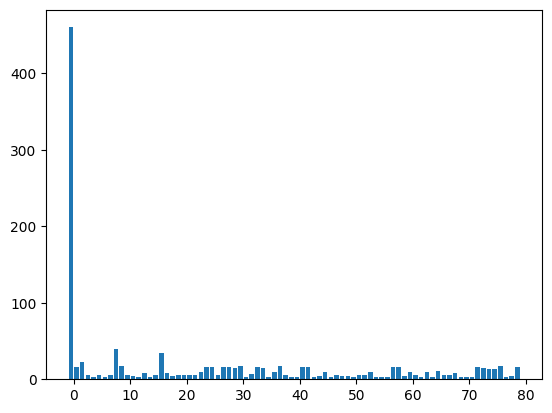

In [15]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(D)
cluster_number = 80

km = HDBSCAN(min_cluster_size=3)
labels = km.fit_predict(X)

print('Silhouette score: ', metrics.silhouette_score(X, labels, metric='euclidean'))

plt.hist(labels, bins=np.arange(-1, cluster_number), rwidth=0.8)

In [16]:
import string
from collections import Counter

def top_n_words(text_list, n=20, filter_common_array=None):
    words = []
    for text in text_list:
        text = text.translate(str.maketrans('', '', string.punctuation))
        words.extend(text.lower().split())

    # Filter common words
    if filter_common_array:
        words = [word for word in words if word not in filter_common_array]

    # Count the words
    word_counts = Counter(words)

    return word_counts.most_common(n)


res = pd.DataFrame({
    'docstring': D,
    'label': labels
})

#docstring_mx['label'] = labels
test_df['label'] = labels

res.head()

docstring  label
0                 show splash     -1
1      print version and exit      7
2          Animation   init       -1
3  Animation  typecheck input     -1
4             Animation begin     -1

In [24]:
list(test_df[test_df['label'] == 6]['combinedName'])

['ManimColor darker',
 'ManimColor lighter',
 'ManimColor contrasting',
 'ManimColor opacity',
 'ManimColor   mul  ',
 'ManimColor   truediv  ']

---
### TF-IDF + Lemmatize + Clustering

In [4]:
test_df = pd.read_csv('graph/sklearn/cg_nodes.csv')
test_df = test_df[test_df['docstring'].notna()].reset_index(drop=True)
dcs = test_df['docstring'].to_numpy()

In [5]:
test_df[test_df['docstring'].str.contains('likelihood')]

combinedName  \
43    DiscriminantAnalysisPredictionMixin.decision_f...   
335                                      log_likelihood   
336                                empirical_covariance   
339                             EmpiricalCovariance.fit   
340                           EmpiricalCovariance.score   
342                                          _objective   
347                                graphical_lasso_path   
542             LatentDirichletAllocation._approx_bound   
543                     LatentDirichletAllocation.score   
544   LatentDirichletAllocation._perplexity_precomp_...   
545                LatentDirichletAllocation.perplexity   
566                                   _assess_dimension   
573                                   PCA.score_samples   
574                                           PCA.score   
990   _BinaryGaussianProcessClassifierLaplace.log_ma...   
996   GaussianProcessClassifier.log_marginal_likelihood   
1000   GaussianProcessRegressor.log_marginal_likelihood   
1120             BayesianRidge._log_marginal_likelihood   
1217                   test_bayesian_ridge_score_values   
1247           test_multinomial_identifiability_on_iris   
1402                            class_likelihood_ratios   
1408                                           log_loss   
1495   test_likelihood_ratios_raise_warning_deprecation   
1496  test_likelihood_ratios_replace_undefined_by_worst   
1497  test_likelihood_ratios_wrong_dict_replace_unde...   
1498   test_likelihood_ratios_replace_undefined_by_0_fp   
1499   test_likelihood_ratios_replace_undefined_by_0_tn   
1611                                    BaseMixture.fit   
1612                            BaseMixture.fit_predict   
1614                          BaseMixture.score_samples   
1630       BayesianGaussianMixture._compute_lower_bound   
1801                        KernelDensity.score_samples   
1849                                  BernoulliRBM._fit   
1850                         BernoulliRBM.score_samples   
1897                               PowerTransformer.fit   
1902                                    power_transform   
2249                                 _yeojohnson_lambda   

                                          function_code  \
43    def decision_function(self, X):\n    """Apply ...   
335   @validate_params({'emp_cov': [np.ndarray], 'pr...   
336   @validate_params({'X': ['array-like'], 'assume...   
339   @_fit_context(prefer_skip_nested_validation=Tr...   
340   def score(self, X_test, y=None):\n    """Compu...   
342   def _objective(mle, precision_, alpha):\n    "...   
347   def graphical_lasso_path(X, alphas, cov_init=N...   
542   def _approx_bound(self, X, doc_topic_distr, su...   
543   def score(self, X, y=None):\n    """Calculate ...   
544   def _perplexity_precomp_distr(self, X, doc_top...   
545   def perplexity(self, X, sub_sampling=False):\n...   
566   def _assess_dimension(spectrum, rank, n_sample...   
573   def score_samples(self, X):\n    """Return the...   
574   def score(self, X, y=None):\n    """Return the...   
990   def log_marginal_likelihood(self, theta=None, ...   
996   def log_marginal_likelihood(self, theta=None, ...   
1000  def log_marginal_likelihood(self, theta=None, ...   
1120  def _log_marginal_likelihood(self, n_samples, ...   
1217  def test_bayesian_ridge_score_values():\n    "...   
1247  @pytest.mark.filterwarnings("ignore:.*'multi_c...   
1402  @validate_params({'y_true': ['array-like', 'sp...   
1408  @validate_params({'y_true': ['array-like'], 'y...   
1495  @pytest.mark.parametrize('raise_warning', [Tru...   
1496  def test_likelihood_ratios_replace_undefined_b...   
1497  @pytest.mark.parametrize('replace_undefined_by...   
1498  @pytest.mark.parametrize('replace_undefined_by...   
1499  @pytest.mark.parametrize('replace_undefined_by...   
1611  def fit(self, X, y=None):\n    """Estimate mod...   
1612  @_fit_context(prefer_skip_nested_validation=Tr...   
1614  def score_samples(self, 

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Első futáskor ezeket töltsd le:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Az NLTK POS címkéből WordNet POS-ra konvertálás."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_sentence(sentence):
    """Egy teljes mondat lemmatizálása helyes szófajjal."""
    words = nltk.word_tokenize(sentence)
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    return " ".join(lemmatized_words)


D = [lemmatize_sentence(s) for s in dcs]
D = [s.replace(':', ' ').replace('\\n', ' ').replace('-', ' ').replace('_', ' ')
      .replace('.', ' . ').replace(',', ' ').replace('`', ' ').replace('\\n\\n', ' ')
      .replace('(', ' ( ').replace(')', ' ) ').replace('\'', '')
      .replace('}', ' } ').replace('{', ' { ').replace('[', ' [ ').replace(']', ' ] ').lower().split() for s in dcs]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\szmid\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\szmid\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\szmid\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\szmid\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\szmid\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\szmid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\szmid\AppData\Roaming\nltk_data...
[nltk_data

In [8]:
D[43]

['apply',
 'decision',
 'function',
 'to',
 'an',
 'array',
 'of',
 'samples',
 '.',
 'parameters',
 'x',
 '{',
 'array',
 'like',
 'sparse',
 'matrix',
 '}',
 'of',
 'shape',
 '(',
 'n',
 'samples',
 'n',
 'features',
 ')',
 'array',
 'of',
 'samples',
 '(',
 'test',
 'vectors',
 ')',
 '.',
 'returns',
 'y',
 'scores',
 'ndarray',
 'of',
 'shape',
 '(',
 'n',
 'samples',
 ')',
 'or',
 '(',
 'n',
 'samples',
 'n',
 'classes',
 ')',
 'decision',
 'function',
 'values',
 'related',
 'to',
 'each',
 'class',
 'per',
 'sample',
 '.',
 'in',
 'the',
 'two',
 'class',
 'case',
 'the',
 'shape',
 'is',
 '(',
 'n',
 'samples',
 ')',
 'giving',
 'the',
 'log',
 'likelihood',
 'ratio',
 'of',
 'the',
 'positive',
 'class',
 '.']

In [26]:
from gensim.models import Word2Vec


# Word2Vec modell tanítása
model = Word2Vec(D, vector_size=12, window=12, min_count=35, workers=4, seed=42)

In [27]:
print(model.wv.most_similar('roc'))
print('-----------------------------------')
print(model.wv.most_similar('likelihood'))
print('-----------------------------------')
print(model.wv.most_similar('probability'))
print('-----------------------------------')
print(model.wv.most_similar('distance'))
print('-----------------------------------')
print(model.wv.most_similar('score'))
print('-----------------------------------')
print(model.wv.most_similar('regression', topn=10))
print('-----------------------------------')
print(model.wv.most_similar('model', topn=10))
print('-----------------------------------')
print(model.wv.most_similar('tree', topn=10))
print('-----------------------------------')
print(model.wv.most_similar('transform', topn=10))

[('auc', 0.9805317521095276), ('curve', 0.9140141010284424), ('recall', 0.8889986872673035), ('calibration', 0.8489419221878052), ('accuracy', 0.8172458410263062), ('score', 0.8034153580665588), ('precision', 0.7889426946640015), ('information', 0.7814672589302063), ('measure', 0.7799555063247681), ('some', 0.7672902941703796)]
-----------------------------------
[('gradient', 0.939789354801178), ('log', 0.8823543190956116), ('intercept', 0.7539700269699097), ('respect', 0.7471969723701477), ('kernel', 0.7389529943466187), ('probabilities', 0.7371670603752136), ('compute', 0.7283245325088501), ('probability', 0.7279054522514343), ('estimates', 0.7265633344650269), ('prediction', 0.7006732821464539)]
-----------------------------------
[('scores', 0.8937419652938843), ('estimates', 0.887582004070282), ('prediction', 0.8622313141822815), ('predicted', 0.8438946604728699), ('probabilities', 0.8338188529014587), ('predictions', 0.8105366826057434), ('log', 0.790542721748352), ('thresholds'

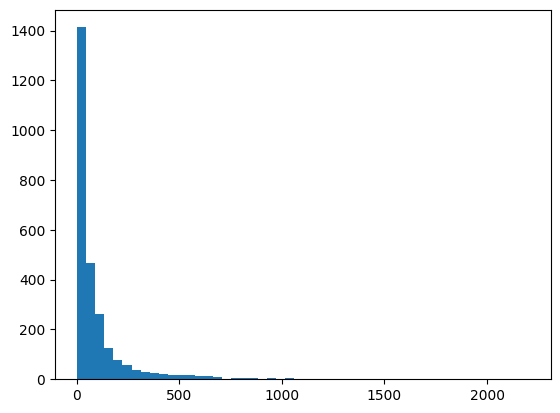

In [28]:
token_length = []
embeddings = []

for s_idx, sentence in enumerate(D):

    mx_representation = []
    for idx in range(250):
        if idx >= len(sentence):
            mx_representation.append(np.zeros(model.vector_size))
            continue
        else:
            word = sentence[idx]
            if word in model.wv:
                mx_representation.append(model.wv[word])
            else:
                mx_representation.append(np.zeros(model.vector_size))

    token_length.append(len(D[s_idx]))
    #print(np.array(mx_representation).shape)
    embeddings.append(np.array(mx_representation))

plt.hist(token_length, bins=50);

<Axes: >

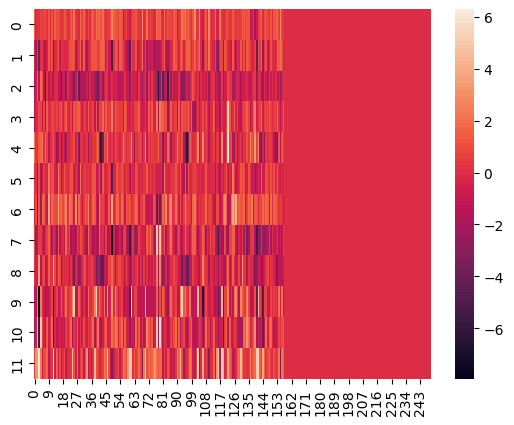

In [29]:
sns.heatmap(embeddings[131].T)

In [30]:
flattened_embeddings = [item.flatten() for item in embeddings]

Silhouette score:  0.11056200325523509


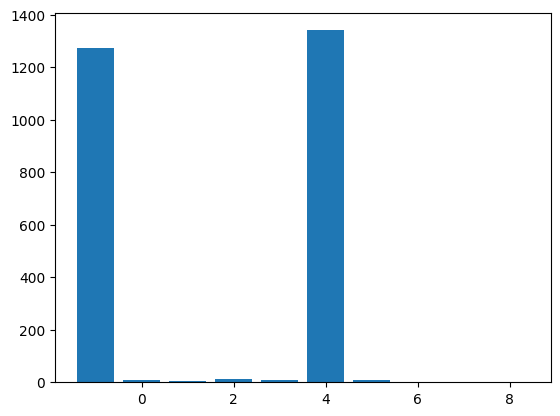

In [17]:
from sklearn.cluster import KMeans, HDBSCAN

hdb = HDBSCAN(min_cluster_size=5)
hdb.fit(flattened_embeddings)

# Silhouette score
from sklearn import metrics
print('Silhouette score: ', metrics.silhouette_score(flattened_embeddings, hdb.labels_, metric='euclidean'))

# PLot cluster size
plt.hist(hdb.labels_, bins=np.arange(-1, 10) - 0.5, rwidth=0.8);

In [234]:
resdf = test_df.copy()
resdf['labels'] = hdb.labels_
resdf.loc[resdf['labels'] == 4].head(20)

combinedName  \
27        CalibratedClassifierCV.get_metadata_routing   
145                     Pipeline.get_metadata_routing   
317   TransformedTargetRegressor.get_metadata_routing   
349             GraphicalLassoCV.get_metadata_routing   
614                  BaseBagging.get_metadata_routing   
936                        RFECV.get_metadata_routing   
938    SequentialFeatureSelector.get_metadata_routing   
1127               LinearModelCV.get_metadata_routing   
1137                      LarsCV.get_metadata_routing   
1155        LogisticRegressionCV.get_metadata_routing   
1661  TunedThresholdClassifierCV.get_metadata_routing   
1683                BaseSearchCV.get_metadata_routing   

                                          function_code  \
27    def get_metadata_routing(self):\n    """Get me...   
145   def get_metadata_routing(self):\n    """Get me...   
317   def get_metadata_routing(self):\n    """Get me...   
349   def get_metadata_routing(self):\n    """Get me...   
614   def get_metadata_routing(self):\n    """Get me...   
936   def get_metadata_routing(self):\n    """Get me...   
938   def get_metadata_routing(self):\n    """Get me...   
1127  def get_metadata_routing(self):\n    """Get me...   
1137  def get_metadata_routing(self):\n    """Get me...   
1155  def get_metadata_routing(self):\n    """Get me...   
1661  def get_metadata_routing(self):\n    """Get me...   
1683  def get_metadata_routing(self):\n    """Get me...   

                                              docstring  \
27    Get metadata routing of this object.\n\nPlease...   
145   Get metadata routing of this object.\n\nPlease...   
317   Get metadata routing of this object.\n\nPlease...   
349   Get metadata routing of this object.\n\nPlease...   
614   Get metadata routing of this object.\n\nPlease...   
936   Get metadata routing of this object.\n\nPlease...   
938   Get metadata routing of this object.\n\nPlease...   
1127  Get metadata routing of this object.\n\nPlease...   
1137  Get metadata routing of this object.\n\nPlease...   
1155  Get metadata routing of this object.\n\nPlease...   
1661  Get metadata routing of this object.\n\nPlease...   
1683  Get metadata routing of this object.\n\nPlease...   

                                    docstring_embedding  func_id  labels  
27    [0.049725525081157684, -0.028019195422530174, ...       34       4  
145   [0.049725525081157684, -0.028019195422530174, ...      189       4  
317   [0.0484657846391201, -0.03588956966996193, -0....      511       4  
349   [0.04754064232110977, -0.0346713587641716, -0....      571       4  
614   [0.04754064232110977, -0.0346713587641716, -0....     1116       4  
936   [0.0484657846391201, -0.03588956966996193, -0....     1728       4  
938   [0.0484657846391201, -0.03588956966996193, -0....     1732       4  
1127  [0.05723058059811592, -0.03209676221013069, -0...     2150       4  
1137  [0.05723058059811592, -0.03209676221013069, -0...     2164       4  
1155  [0.05723058059811592, -0.03209676221013069, -0...     2184       4  
1661  [0.049725525081157684, -0.028019195422530174, ...     3463       4  
1683  [0.05723058059811592, -0.03209676221013069, -0...     3493       4

Embedding similarity

<Axes: >

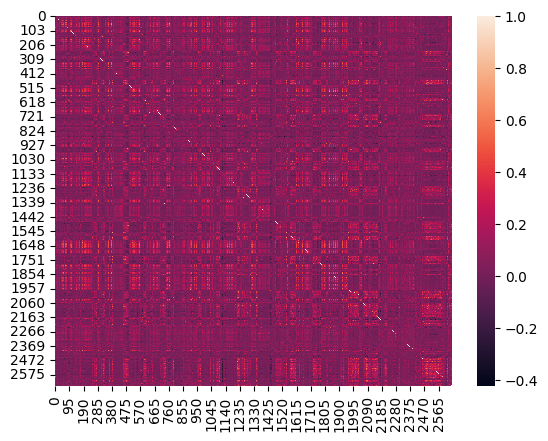

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

S = cosine_similarity(flattened_embeddings)

sns.heatmap(S)

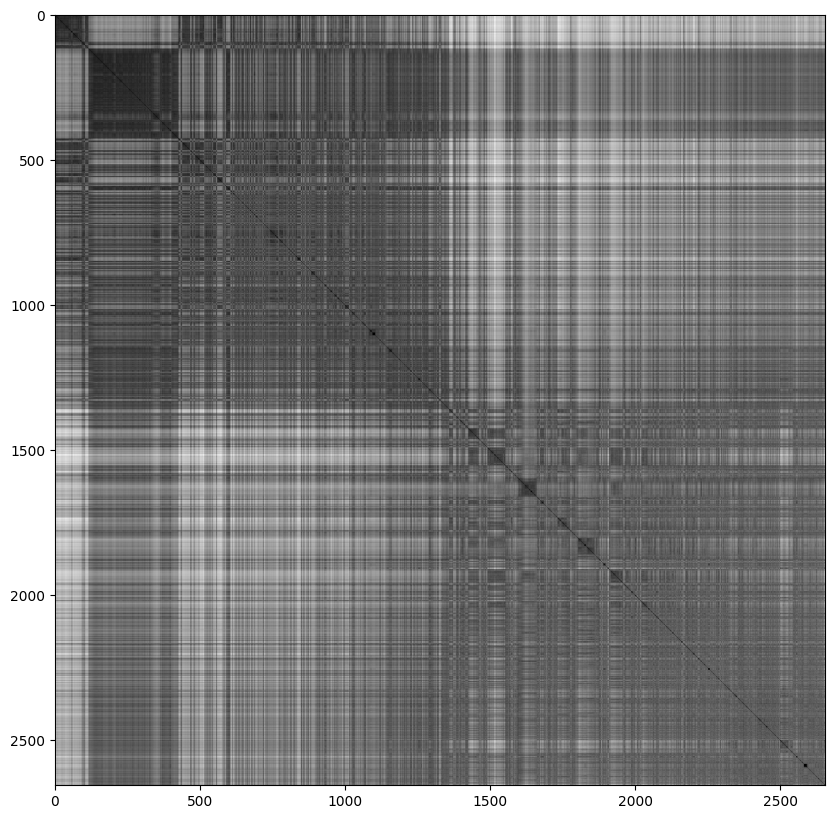

In [ ]:
import numpy as np

# Példa: Van egy cosine similarity mátrix S
DMX = 1 - S  # disszimilaritás mátrix

# VAT
vat(DMX)

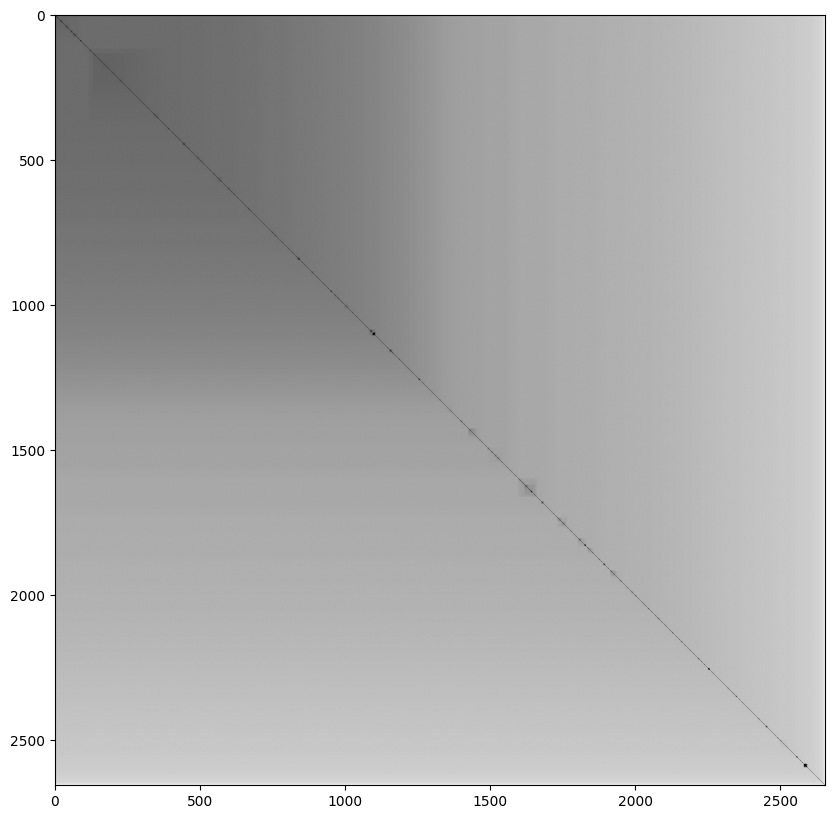

In [34]:
# iVAT
ivat(DMX)

---
### Function name ebedding

In [79]:
test_df = pd.read_csv('graph/sklearn/cg_nodes.csv')
test_df['function_name'] = test_df['combinedName'].apply(lambda x: x.split('.')[-1] if '.' in x else x)
test_df['function_name'] = test_df['function_name'].apply(
    lambda x: x[0] + x[1:].replace('_', ' ') if x.startswith('_') else x.replace('_', ' ')
)
test_df

combinedName  \
0                                        clone   
1                          _clone_parametrized   
2               BaseEstimator._get_param_names   
3                     BaseEstimator.get_params   
4               BaseEstimator._get_params_html   
...                                        ...   
5829  test_binomial_vs_alternative_formulation   
5830                        test_predict_proba   
5831                          test_loss_pickle   
5832     test_tweedie_log_identity_consistency   
5833                         raise_build_error   

                                          function_code  \
0     def clone(estimator, *, safe=True):\n    """Co...   
1     def _clone_parametrized(estimator, *, safe=Tru...   
2     @classmethod\ndef _get_param_names(cls):\n    ...   
3     def get_params(self, deep=True):\n    """\n   ...   
4     def _get_params_html(self, deep=True):\n    ""...   
...                                                 ...   
5829  @pytest.mark.parametrize('y_true', (np.array([...   
5830  @pytest.mark.parametrize('loss', LOSS_INSTANCE...   
5831  @pytest.mark.parametrize('loss', LOSS_INSTANCE...   
5832  @pytest.mark.parametrize('p', [-1.5, 0, 1, 1.5...   
5833  def raise_build_error(e):\n    local_dir = os....   

                                              docstring  \
0     Construct a new unfitted estimator with the sa...   
1     Default implementation of clone. See :func:`sk...   
2                 Get parameter names for the estimator   
3     Get parameters for this estimator.\n\nParamete...   
4     Get parameters for this estimator with a speci...   
...                                                 ...   
5829  Test that both formulations of the binomial de...   
5830  Test that predict_proba and gradient_proba wor...   
5831                   Test that losses can be pickled.   
5832  Test for identical losses when only the link f...   
5833                                                NaN   

                                    docstring_embedding  func_id  \
0     [-0.13635297119617462, -0.10193724930286407, 0...        0   
1     [-0.12790191173553467, -0.0752759575843811, -0...        1   
2     [-0.005924790631979704, -0.017579255625605583,...        2   
3     [-0.0028749655466526747, -0.020313695073127747...        3   
4     [-0.03902079910039902, -0.03539375588297844, -...        4   
...                                                 ...      ...   
5829  [0.0541771799325943, 0.01487375795841217, 0.05...     5829   
5830  [-0.08995843678712845, -0.11696255952119827, -...     5830   
5831  [-0.06052705645561218, 0.028919026255607605, 0...     5831   
5832  [-0.026912715286016464, 0.008891728706657887, ...     5832   
5833  [-0.1188383623957634, 0.0482986755669117, -0.0...     5833   

                                 function_name  
0                                        clone  
1                          _clone parametrized  
2                             _get param names  
3                                   get params  
4                             _get params html  
...                                        ...  
5829  test binomial vs alternative formulation  
5830                        test predict proba  
5831                          test loss pickle  
5832     test tweedie log identity consistency  
5833                         raise build error  

[5834 rows x 6 columns]

In [80]:
# Load CodeBERT
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)  # Move model to GPU if available
model.eval()  # Set model to evaluation mode

# Function to generate embeddings
def get_codebert_embedding(code_snippet):
    """
    Generate a CodeBERT embedding for a code snippet.
    Returns the mean pooled embedding as a list.
    """
    tokens = tokenizer(code_snippet, truncation=True, max_length=19, return_tensors="pt")['input_ids']
    tokens = torch.cat([tokens, torch.tensor([[tokenizer.eos_token_id]], device=tokens.device)], dim=1)
    tokens = tokens.to(device)  # Move tokens to GPU if available

    with torch.no_grad():
        outputs = model(tokens)[0][0]

    seq_len, hidden_size = outputs.shape
    if seq_len < 20:
        pad_len = 20 - seq_len
        padding = torch.zeros((pad_len, hidden_size), device=outputs.device)
        outputs = torch.cat([outputs, padding], dim=0)
    elif seq_len > 20:
        outputs = outputs[:20]

    return outputs.cpu().numpy().flatten()

# Apply to the dataframe
test_df["func_name_embedding"] = test_df["function_name"].apply(get_codebert_embedding)

<Axes: >

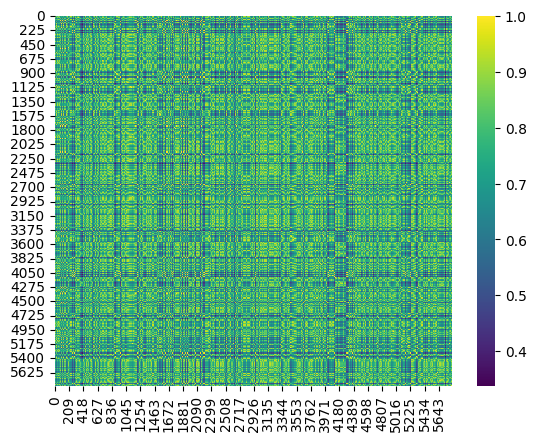

In [81]:
cosine_similarity_matrix = metrics.pairwise.cosine_similarity(test_df["func_name_embedding"].tolist())
sns.heatmap(cosine_similarity_matrix, cmap='viridis')

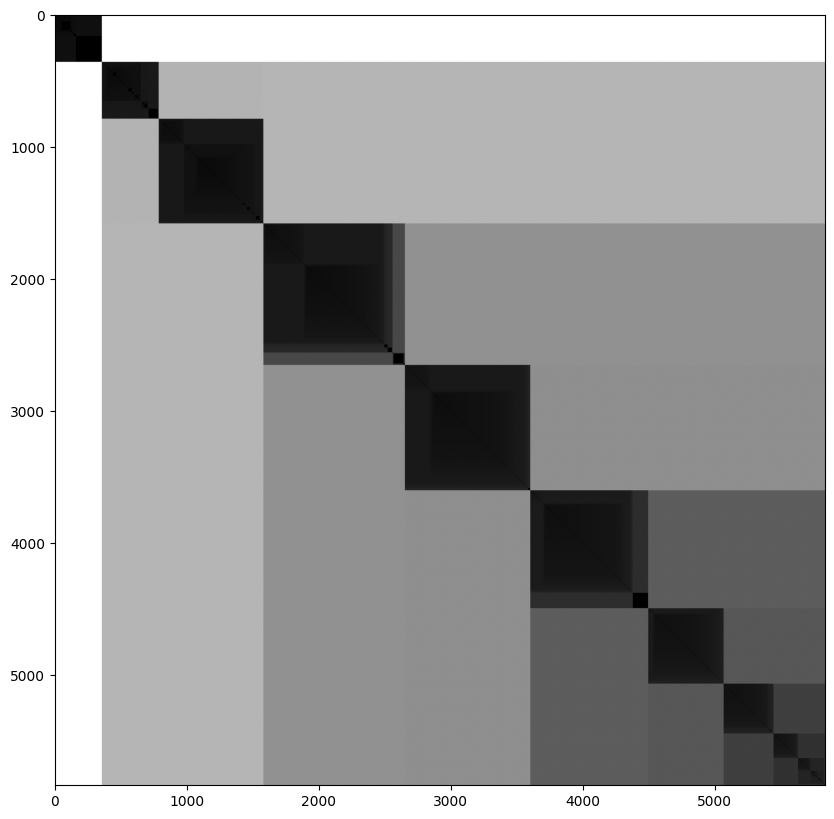

In [82]:
odm, ordering = ivat(cosine_similarity_matrix, return_odm=True)

<Axes: >

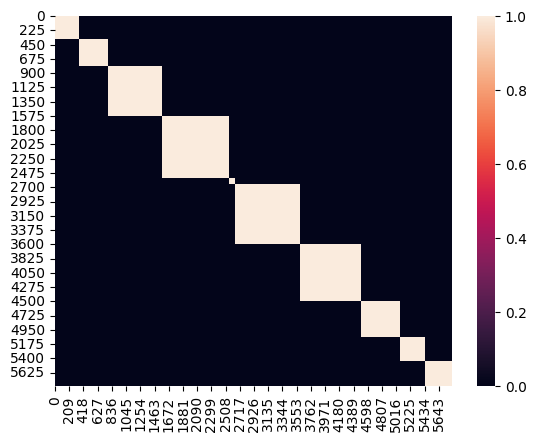

In [83]:
filtered_odm = odm < 1.334
sns.heatmap(filtered_odm)

In [84]:
import numpy as np

def detect_clusters_from_binary_diagonal_matrix(binary_matrix: np.ndarray):
    """
    Detect clusters as contiguous square blocks of 1s along the diagonal
    of a binary matrix (usually thresholded iVAT result).

    Parameters
    ----------
    binary_matrix : np.ndarray
        A square binary matrix with 1s in diagonal blocks representing clusters.

    Returns
    -------
    clusters : list of tuples
        Each tuple is (start_index, end_index) for a detected cluster.
    """

    n = binary_matrix.shape[0]
    visited = np.zeros(n, dtype=bool)
    clusters = []

    i = 0
    while i < n:
        if visited[i]:
            i += 1
            continue

        # Start a potential cluster at i
        cluster_end = i
        while (
            cluster_end + 1 < n
            and binary_matrix[cluster_end, cluster_end + 1] == 1
            and binary_matrix[cluster_end + 1, cluster_end] == 1
        ):
            cluster_end += 1

        # Mark all indices in this cluster as visited
        visited[i : cluster_end + 1] = True
        clusters.append((i, cluster_end))

        i = cluster_end + 1

    return clusters

clusters = detect_clusters_from_binary_diagonal_matrix(filtered_odm)

for idx, (start, end) in enumerate(clusters):
    print(f"Cluster {idx + 1}: [{start} - {end}]")


Cluster 1: [0 - 354]
Cluster 2: [355 - 783]
Cluster 3: [784 - 785]
Cluster 4: [786 - 1577]
Cluster 5: [1578 - 1578]
Cluster 6: [1579 - 2559]
Cluster 7: [2560 - 2650]
Cluster 8: [2651 - 3599]
Cluster 9: [3600 - 3600]
Cluster 10: [3601 - 4493]
Cluster 11: [4494 - 5065]
Cluster 12: [5066 - 5443]
Cluster 13: [5444 - 5833]


In [85]:
test_df['label'] = -1
cluster_number = 0

for cluster in clusters:
    if cluster[0] == cluster[1]:
        continue
    else:
        for row_idx in ordering[cluster[0]:cluster[1]]:
            test_df.loc[row_idx, 'label'] = cluster_number
        cluster_number += 1

In [86]:
cluster_number

11

In [91]:
list(test_df.loc[test_df['label'] == 4]['function_name'])

['_get param names',
 '_get params html',
 '_validate params',
 'get submatrix',
 'get feature names out',
 'get feature names out',
 'is outlier detector',
 '_get estimator',
 'predict proba',
 '_fit calibrator',
 'predict proba',
 'calibration curve',
 'pytest generate tests',
 'print changed only false',
 'predict proba',
 '_decision function',
 'predict proba',
 'isotonic regression',
 'get feature names out',
 'get feature names out',
 '_get kernel params',
 '_partial fit binary',
 '_predict binary',
 'predict proba',
 'predict proba',
 '_fit estimator',
 'predict proba',
 '_get estimator',
 '_update mean variance',
 '_check X y',
 '_check X y',
 '_cached transform',
 '_validate steps',
 '_check method params',
 'predict proba',
 'get feature names out',
 '_name estimators',
 '_fit transform one',
 'get feature names out',
 '_parallel func',
 '_update transformer list',
 '_check input size',
 '_make random matrix',
 '_make random matrix',
 '_affinity propagation',
 '_single linkag

Silhouette score:  0.20057855546474457
Cluster labels: [ 3 13  4 ...  9  2 10]


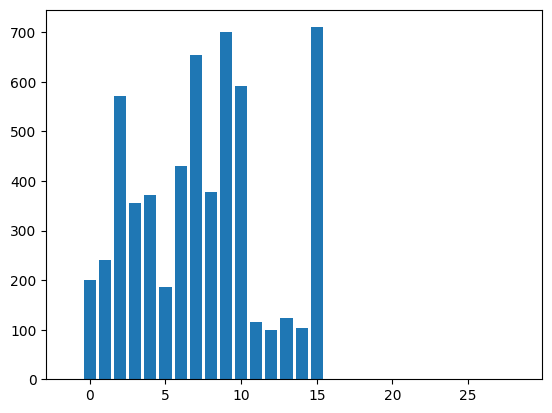

In [92]:
X = test_df["func_name_embedding"].tolist()

kmeans = KMeans(n_clusters=16, random_state=42)
kmeans.fit(X)

print('Silhouette score: ', metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))

print('Cluster labels:', kmeans.labels_)
plt.hist(kmeans.labels_, bins=np.arange(-1, 30) - 0.5, rwidth=0.8);

test_df['label'] = kmeans.labels_

In [99]:
list(test_df.loc[test_df['label'] == 6]['function_name'])

['get params',
 'set params',
 'fit predict',
 'get indices',
 'get shape',
 'fit transform',
 'fit predict',
 'predict',
 'predict',
 'from predictions',
 'predict',
 'predict',
 'predict',
 'check increasing',
 '_transform',
 'predict',
 'predict',
 'partial fit',
 'predict',
 'partial fit',
 'predict',
 'predict',
 '_check',
 'partial fit',
 'predict',
 'partial fit',
 'predict',
 'partial fit',
 '_count',
 '_count',
 '_count',
 '_count',
 'set output',
 '_iter',
 '_fit',
 'fit transform',
 'predict',
 'score samples',
 'set output',
 '_iter',
 'fit transform',
 'set config',
 'config context',
 'predict',
 'ward tree',
 '_fit',
 '_fit',
 '_fit',
 '_fit',
 'partial fit',
 'predict',
 'iter leaves',
 'predict',
 'dbscan',
 'fit predict',
 'k means',
 'predict',
 'partial fit',
 'mean shift',
 'predict',
 'check threshold',
 'test threshold',
 'test sparse',
 'test boundaries',
 'test transform',
 'test parallel',
 'fit predict',
 'set output',
 '_iter',
 'fit transform',
 'predict',


---
### Function name TF-IDF

In [96]:
test_df = pd.read_csv('graph/manim/cg_nodes.csv')
test_df['function_name'] = test_df['combinedName']#.apply(lambda x: x.split('.')[-1] if '.' in x else x)
test_df['function_name'] = test_df['function_name'].apply(
    lambda x: x[0] + ' ' + x[1:].replace('_', ' ') if x.startswith('_') else x.replace('_', ' ')
)
test_df

combinedName  \
0                    show_splash   
1         print_version_and_exit   
2             Animation.__init__   
3     Animation._typecheck_input   
4                Animation.begin   
...                          ...   
1409  ManimConfig.custom_folders   
1410      ManimConfig.input_file   
1411     ManimConfig.output_file   
1412    ManimConfig.tex_template   
1413                  tempconfig   

                                          function_code  \
0     def show_splash(ctx: click.Context, param: cli...   
1     def print_version_and_exit(ctx: click.Context,...   
2     def __init__(self, mobject: Mobject | None, la...   
3     def _typecheck_input(self, mobject: Mobject | ...   
4     def begin(self) -> None:\n    """Begin the ani...   
...                                                 ...   
1409  @custom_folders.setter\ndef custom_folders(sel...   
1410  @input_file.setter\ndef input_file(self, value...   
1411  @output_file.setter\ndef output_file(self, val...   
1412  @property\ndef tex_template(self) -> TexTempla...   
1413  @contextmanager\ndef tempconfig(temp: ManimCon...   

                                              docstring  \
0     When giving a value by console, show an initia...   
1     Same as :func:`show_splash`, but also exit whe...   
2                                                   NaN   
3                                                   NaN   
4     Begin the animation.\n\nThis method is called ...   
...                                                 ...   
1409                                                NaN   
1410                                                NaN   
1411                                                NaN   
1412  Template used when rendering Tex.  See :class:...   
1413  Context manager that temporarily modifies the ...   

                                    docstring_embedding  func_id  \
0     [0.04961501806974411, 0.03033692203462124, -0....        0   
1     [0.017242757603526115, 0.034651197493076324, -...        1   
2     [-0.11883845180273056, 0.0482986681163311, -0....        2   
3     [-0.11883839964866638, 0.04829868674278259, -0...        3   
4     [-0.023804470896720886, -0.042486000806093216,...        4   
...                                                 ...      ...   
1409  [-0.11883839964866638, 0.04829868674278259, -0...     1409   
1410  [-0.11883839964866638, 0.04829868674278259, -0...     1410   
1411  [-0.11883839964866638, 0.04829868674278259, -0...     1411   
1412  [-0.07564476132392883, 0.11539892107248306, -0...     1412   
1413  [-0.012804128229618073, 0.057353291660547256, ...     1413   

                   function_name  
0                    show splash  
1         print version and exit  
2             Animation.  init    
3     Animation. typecheck input  
4                Animation.begin  
...                          ...  
1409  ManimConfig.custom folders  
1410      ManimConfig.input file  
1411     ManimConfig.output file  
1412    ManimConfig.tex template  
1413                  tempconfig  

[1414 rows x 6 columns]

In [97]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(test_df['function_name'])

<Axes: >

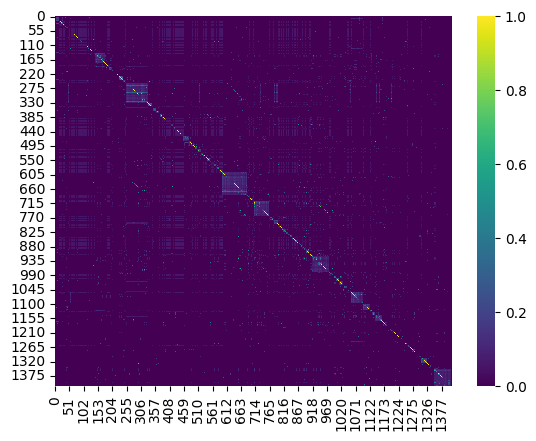

In [100]:
cosine_similarity_matrix = metrics.pairwise.cosine_similarity(X.toarray())
sns.heatmap(cosine_similarity_matrix, cmap='viridis')

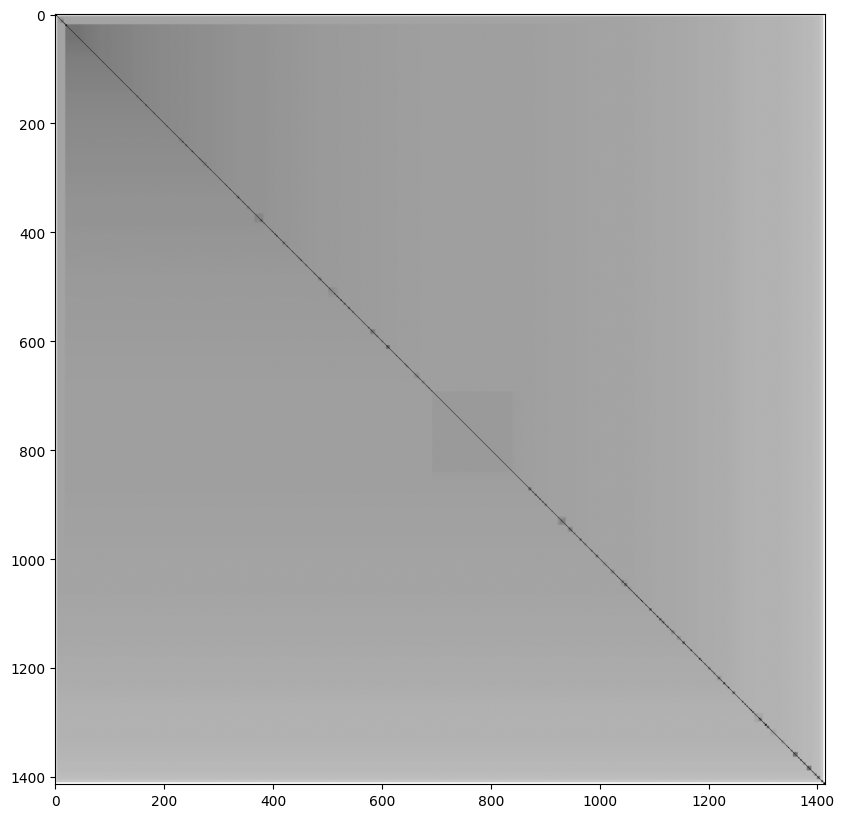

In [101]:
odm, ordering = ivat(cosine_similarity_matrix, return_odm=True)

<Axes: >

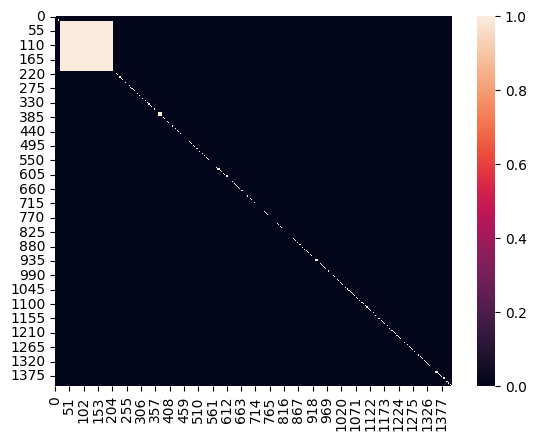

In [103]:
filtered_odm = odm < 1.2
sns.heatmap(filtered_odm)

Silhouette score:  0.020925654347313055
Cluster labels: [ 1 14 11 ...  9 14  1]


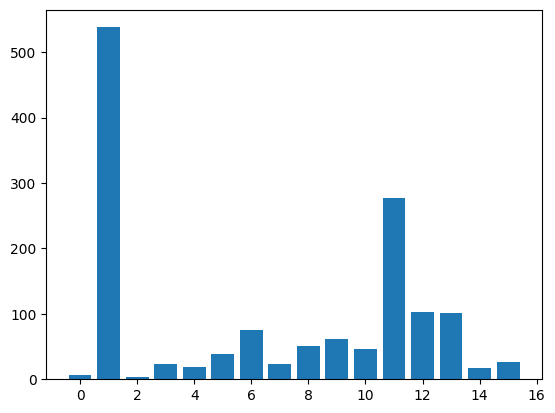

In [138]:
num_clusters = 16
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

print('Silhouette score: ', metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))

print('Cluster labels:', kmeans.labels_)
plt.hist(kmeans.labels_, bins=np.arange(0, num_clusters + 1) - 0.5, rwidth=0.8);

test_df['label'] = kmeans.labels_

In [143]:
list(test_df.loc[test_df['label'] == 15]['combinedName'])

['Circle.point_at_angle',
 'Line.set_angle',
 'Angle.__init__',
 'CoordinateSystem.__init__',
 'CoordinateSystem.point_to_polar',
 'CoordinateSystem._get_axis_label',
 'CoordinateSystem.get_line_from_axis_to_point',
 'CoordinateSystem.plot',
 'CoordinateSystem.plot_implicit_curve',
 'CoordinateSystem.plot_parametric_curve',
 'CoordinateSystem.plot_polar_graph',
 'CoordinateSystem.plot_surface',
 'CoordinateSystem.input_to_graph_point',
 'CoordinateSystem.get_graph_label',
 'CoordinateSystem.get_riemann_rectangles',
 'CoordinateSystem.get_area',
 'CoordinateSystem.angle_of_tangent',
 'CoordinateSystem.plot_derivative_graph',
 'CoordinateSystem.plot_antiderivative_graph',
 'CoordinateSystem.get_secant_slope_group',
 'CoordinateSystem.get_vertical_lines_to_graph',
 'CoordinateSystem.get_T_label',
 'OpenGLLine.set_angle',
 'quaternion_from_angle_axis',
 'angle_axis_from_quaternion',
 'angle_of_vector',
 'angle_between_vectors']

In [144]:
cluster_summaries = {
    0: "Barchart related functions/methods.",
    1: "Random functions/methods.",
    2: "Manim functions/methods.",
    3: "Bezier points and curves related functions/methods.",
    4: "Remove and delete functions/methods.",
    5: "Points and alignments related functions/methods.",
    6: "OpenGLMobject related functions/methods.",
    7: "SceneFileWriter related functions/methods.",
    8: "Add and extender functions/methods.",
    9: "ManimConfig related function/methods.",
    10: "Camera and background related functions.",
    11: "Constructur (__init__) functions/methods.",
    12: "Get, set and curve related functions/mehods.",
    13: "MObject related functions/methods.",
    14: "Tex related functions/methods.",
    15: "Coordinate system, vector and angle related functions/methods."
}

In [145]:
cluster_df = test_df[['combinedName', 'function_name', 'label']].copy()
cluster_df['summary'] = cluster_df['label'].map(cluster_summaries)
cluster_df = cluster_df.sort_values(by='label').reset_index(drop=True)
cluster_df

combinedName  \
0                      BarChart._add_x_axis_labels   
1                       BarChart.change_bar_values   
2                               BarChart._add_bars   
3                             BarChart._create_bar   
4                                BarChart.__init__   
...                                            ...   
1409  CoordinateSystem.get_vertical_lines_to_graph   
1410                  CoordinateSystem.get_T_label   
1411                               angle_of_vector   
1412             CoordinateSystem.plot_polar_graph   
1413       CoordinateSystem.get_riemann_rectangles   

                                     function_name  label  \
0                      BarChart. add x axis labels      0   
1                       BarChart.change bar values      0   
2                               BarChart. add bars      0   
3                             BarChart. create bar      0   
4                                BarChart.  init        0   
...                                            ...    ...   
1409  CoordinateSystem.get vertical lines to graph     15   
1410                  CoordinateSystem.get T label     15   
1411                               angle of vector     15   
1412             CoordinateSystem.plot polar graph     15   
1413       CoordinateSystem.get riemann rectangles     15   

                                                summary  
0                   Barchart related functions/methods.  
1                   Barchart related functions/methods.  
2                   Barchart related functions/methods.  
3                   Barchart related functions/methods.  
4                   Barchart related functions/methods.  
...                                                 ...  
1409  Coordinate system, vector and angle related fu...  
1410  Coordinate system, vector and angle related fu...  
1411  Coordinate system, vector and angle related fu...  
1412  Coordinate system, vector and angle related fu...  
1413  Coordinate system, vector and angle related fu...  

[1414 rows x 4 columns]

In [147]:
cluster_df.to_csv('function_clustering/manim/clustered_functions.csv', index=False)

In [148]:
test_df = test_df.merge(cluster_df[['combinedName', 'summary']], on='combinedName', how='left')
test_df

combinedName  \
0                    show_splash   
1         print_version_and_exit   
2             Animation.__init__   
3     Animation._typecheck_input   
4                Animation.begin   
...                          ...   
1421  ManimConfig.custom_folders   
1422      ManimConfig.input_file   
1423     ManimConfig.output_file   
1424    ManimConfig.tex_template   
1425                  tempconfig   

                                          function_code  \
0     def show_splash(ctx: click.Context, param: cli...   
1     def print_version_and_exit(ctx: click.Context,...   
2     def __init__(self, mobject: Mobject | None, la...   
3     def _typecheck_input(self, mobject: Mobject | ...   
4     def begin(self) -> None:\n    """Begin the ani...   
...                                                 ...   
1421  @custom_folders.setter\ndef custom_folders(sel...   
1422  @input_file.setter\ndef input_file(self, value...   
1423  @output_file.setter\ndef output_file(self, val...   
1424  @property\ndef tex_template(self) -> TexTempla...   
1425  @contextmanager\ndef tempconfig(temp: ManimCon...   

                                              docstring  \
0     When giving a value by console, show an initia...   
1     Same as :func:`show_splash`, but also exit whe...   
2                                                   NaN   
3                                                   NaN   
4     Begin the animation.\n\nThis method is called ...   
...                                                 ...   
1421                                                NaN   
1422                                                NaN   
1423                                                NaN   
1424  Template used when rendering Tex.  See :class:...   
1425  Context manager that temporarily modifies the ...   

                                    docstring_embedding  func_id  \
0     [0.04961501806974411, 0.03033692203462124, -0....        0   
1     [0.017242757603526115, 0.034651197493076324, -...        1   
2     [-0.11883845180273056, 0.0482986681163311, -0....        2   
3     [-0.11883839964866638, 0.04829868674278259, -0...        3   
4     [-0.023804470896720886, -0.042486000806093216,...        4   
...                                                 ...      ...   
1421  [-0.11883839964866638, 0.04829868674278259, -0...     1409   
1422  [-0.11883839964866638, 0.04829868674278259, -0...     1410   
1423  [-0.11883839964866638, 0.04829868674278259, -0...     1411   
1424  [-0.07564476132392883, 0.11539892107248306, -0...     1412   
1425  [-0.012804128229618073, 0.057353291660547256, ...     1413   

                   function_name  label  \
0                    show splash      1   
1         print version and exit     14   
2             Animation.  init       11   
3     Animation. typecheck input      1   
4                Animation.begin      1   
...                          ...    ...   
1421  ManimConfig.custom folders      9   
1422      ManimConfig.input file      9   
1423     ManimConfig.output file      9   
1424    ManimConfig.tex template     14   
1425                  tempconfig      1   

                                        summary  
0                     Random functions/methods.  
1                Tex related functions/methods.  
2     Constructur (__init__) functions/methods.  
3                     Random functions/methods.  
4                     Random functions/methods.  
...                                         ...  
1421      ManimConfig related function/methods.  
1422      ManimConfig related function/methods.  
1423      ManimConfig related function/methods.  
1424             Tex related functions/methods.  
1425                  Random functions/methods.  

[1426 rows x 8 columns]

In [149]:
test_df.to_csv('graph/manim/cg_nodes_QNA.csv', index=False)

## Code similarity

In [60]:
code_mx = cg_nodes.loc[cg_nodes['docstring'].notna() & cg_nodes['docstring_embedding'].notna()]
code_mx.head()

combinedName  \
0                           clone   
1             _clone_parametrized   
2  BaseEstimator._get_param_names   
3        BaseEstimator.get_params   
4  BaseEstimator._get_params_html   

                                       function_code  \
0  def clone(estimator, *, safe=True):\n    """Co...   
1  def _clone_parametrized(estimator, *, safe=Tru...   
2  @classmethod\ndef _get_param_names(cls):\n    ...   
3  def get_params(self, deep=True):\n    """\n   ...   
4  def _get_params_html(self, deep=True):\n    ""...   

                                           docstring  \
0  Construct a new unfitted estimator with the sa...   
1  Default implementation of clone. See :func:`sk...   
2              Get parameter names for the estimator   
3  Get parameters for this estimator.\n\nParamete...   
4  Get parameters for this estimator with a speci...   

                                 docstring_embedding  func_id  \
0  [-0.13635297119617462, -0.10193724930286407, 0...        0   
1  [-0.12790191173553467, -0.0752759575843811, -0...        1   
2  [-0.005924790631979704, -0.017579255625605583,...        2   
3  [-0.0028749655466526747, -0.020313695073127747...        3   
4  [-0.03902079910039902, -0.03539375588297844, -...        4   

                                   wo_docstring_code  \
0  def clone(estimator, *, safe=True):\n    if ha...   
1  def _clone_parametrized(estimator, *, safe=Tru...   
2  @classmethod\ndef _get_param_names(cls):\n    ...   
3  def get_params(self, deep=True):\n    out = di...   
4  def _get_params_html(self, deep=True):\n    ou...   

                                           norm_code  \
0  def FUNC_0(ARG_0, *, safe=True):\n    if hasat...   
1  def FUNC_0(ARG_0, *, safe=True):\n    VAR_1 = ...   
2  @classmethod\ndef FUNC_0(ARG_0):\n    VAR_1 = ...   
3  def FUNC_0(self, ARG_1=True):\n    VAR_2 = dic...   
4  def FUNC_0(self, ARG_1=True):\n    VAR_2 = sel...   

                                  codebert_embedding  
0  [-0.1017985   0.08984641 -0.00789921 ...  0.  ...  
1  [-0.19052112 -0.02253832 -0.06405669 ... -0.05...  
2  [-0.09611899  0.0838595  -0.08920947 ...  0.  ...  
3  [-0.22579244  0.04514543 -0.10750947 ...  0.  ...  
4  [-0.16866389 -0.0084414  -0.10579009 ...  0.  ...

---
### Embedding similarity

In [156]:
X = np.vstack(code_mx['codebert_embedding'].to_numpy())

In [157]:
# L2 normalize rows
norms = np.linalg.norm(X, axis=1, keepdims=True)
Xn = X / np.clip(norms, 1e-32, None)

# Cosine similarity matrix
S = Xn @ Xn.T

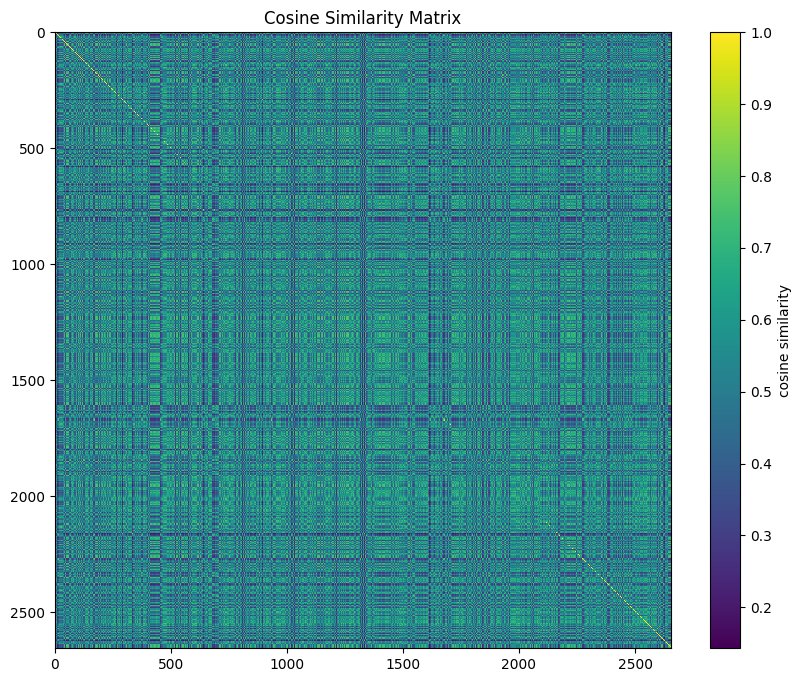

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(S, interpolation="nearest", cmap="viridis")
plt.colorbar(label="cosine similarity")
plt.title("Cosine Similarity Matrix")
plt.show()


In [159]:
TRESHOLD = 0.85

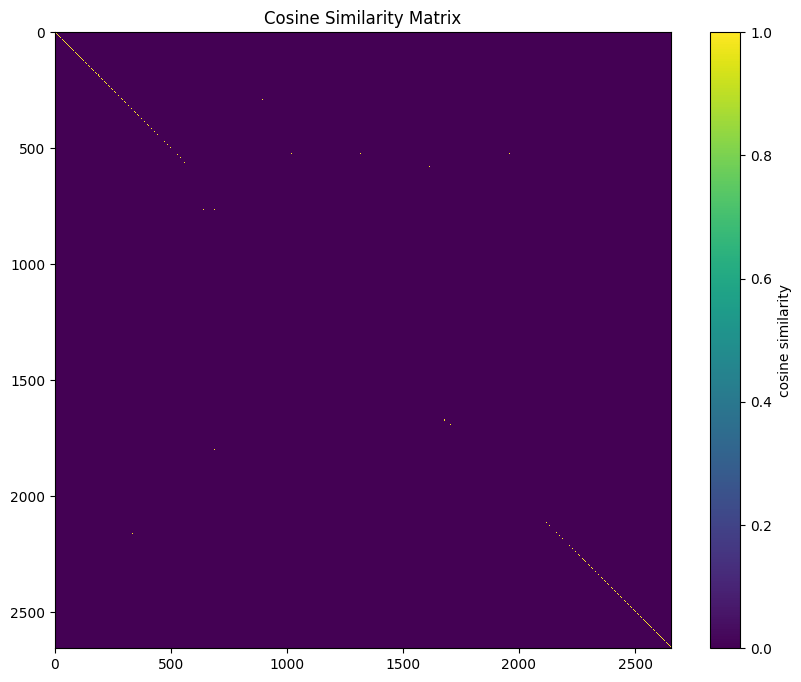

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(S > TRESHOLD, interpolation="nearest", cmap="viridis")
plt.colorbar(label="cosine similarity")
plt.title("Cosine Similarity Matrix")
plt.show()


In [104]:
import numpy as np

def get_high_similarity_pairs(S, threshold=0.65, include_diagonal=False):
    """
    Extract all (i, j, value) pairs from similarity matrix S
    where value >= threshold.
    """
    # Ensure S is a numpy array
    S = np.array(S)

    # Get indices where condition is met
    if include_diagonal:
        rows, cols = np.where(S >= threshold)
    else:
        # Use upper triangle only (avoid duplicates and diagonal)
        rows, cols = np.where(np.triu(S, k=1) >= threshold)

    values = S[rows, cols]
    return list(zip(rows, cols, values))

get_high_similarity_pairs(S, threshold=TRESHOLD, include_diagonal=False)

[(np.int64(18), np.int64(19), np.float32(0.9986403)),
 (np.int64(26), np.int64(686), np.float32(0.86127234)),
 (np.int64(26), np.int64(765), np.float32(0.87483466)),
 (np.int64(26), np.int64(1799), np.float32(0.8831876)),
 (np.int64(33), np.int64(44), np.float32(0.8960772)),
 (np.int64(36), np.int64(1563), np.float32(0.87103015)),
 (np.int64(78), np.int64(199), np.float32(0.8786601)),
 (np.int64(78), np.int64(564), np.float32(0.8544538)),
 (np.int64(78), np.int64(576), np.float32(0.85586756)),
 (np.int64(89), np.int64(96), np.float32(1.0000001)),
 (np.int64(111), np.int64(523), np.float32(0.8640451)),
 (np.int64(111), np.int64(1880), np.float32(0.8786348)),
 (np.int64(111), np.int64(1883), np.float32(0.8786348)),
 (np.int64(111), np.int64(1897), np.float32(0.89291465)),
 (np.int64(166), np.int64(168), np.float32(0.86377114)),
 (np.int64(166), np.int64(581), np.float32(0.8878559)),
 (np.int64(166), np.int64(1843), np.float32(0.8529143)),
 (np.int64(168), np.int64(564), np.float32(0.8955

In [122]:
print(code_mx.iloc[168]['wo_docstring_code'])

def transform(self, X):
    check_is_fitted(self)
    X = validate_data(self, X, accept_sparse=['csr', 'csc'], reset=False, dtype=[np.float64, np.float32])
    return safe_sparse_dot(X, self.components_.T, dense_output=self.dense_output)


In [121]:
print(code_mx.iloc[564]['wo_docstring_code'])

def transform(self, X):
    check_is_fitted(self)
    X = validate_data(self, X, accept_sparse=('csr', 'csc'), dtype=[np.float64, np.float32], reset=False)
    W = self._solve_W(X, self.components_, self._transform_max_iter)
    return W


---
### Levenstein

In [161]:
L = code_mx['wo_docstring_code'].to_numpy()

In [162]:
# Pairwise levenshtein distance
from Levenshtein import distance as levenshtein_distance

n = len(L)
dist_matrix = np.zeros((n, n), dtype=int)

for i in range(n):
    for j in range(i + 1, n):
        dist = levenshtein_distance(L[i], L[j])
        dist_matrix[i, j] = dist
        dist_matrix[j, i] = dist

dist_mx = 1 - (dist_matrix / 10000)

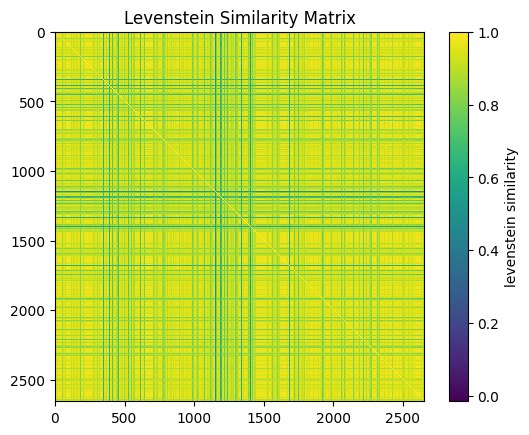

In [163]:
import matplotlib.pyplot as plt

plt.imshow(dist_mx, interpolation="nearest", cmap="viridis")
plt.colorbar(label="levenstein similarity")
plt.title("Levenstein Similarity Matrix")
plt.show()

In [164]:
L_TRESHOLD = 0.99

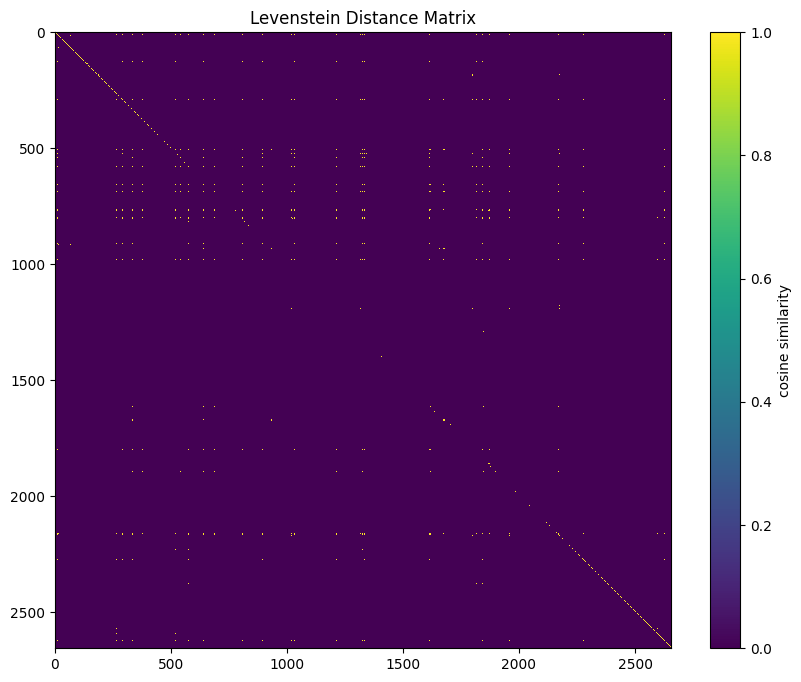

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(dist_mx > L_TRESHOLD, interpolation="nearest", cmap="viridis")
plt.colorbar(label="cosine similarity")
plt.title("Levenstein Distance Matrix")
plt.show()

In [ ]:
import numpy as np


def find_values_above_threshold(matrix, threshold, exclude_diagonal=True):
    rows, cols = np.where(matrix > threshold)
    results = [(r, c, matrix[r, c]) for r, c in zip(rows, cols)]
    
    if exclude_diagonal:
        results = [(r, c, val) for r, c, val in results if r != c]
    
    return results

find_values_above_threshold(dist_mx, threshold=L_TRESHOLD)

[(np.int64(8), np.int64(9), np.float64(0.9952)),
 (np.int64(8), np.int64(574), np.float64(0.9909)),
 (np.int64(8), np.int64(636), np.float64(0.9907)),
 (np.int64(8), np.int64(1866), np.float64(0.9918)),
 (np.int64(9), np.int64(8), np.float64(0.9952)),
 (np.int64(9), np.int64(574), np.float64(0.9903)),
 (np.int64(9), np.int64(636), np.float64(0.9902)),
 (np.int64(9), np.int64(1866), np.float64(0.9912)),
 (np.int64(10), np.int64(11), np.float64(0.9906)),
 (np.int64(10), np.int64(12), np.float64(0.9927)),
 (np.int64(10), np.int64(26), np.float64(0.9922)),
 (np.int64(10), np.int64(33), np.float64(0.9937)),
 (np.int64(10), np.int64(44), np.float64(0.9925)),
 (np.int64(10), np.int64(111), np.float64(0.9914)),
 (np.int64(10), np.int64(112), np.float64(0.9916)),
 (np.int64(10), np.int64(124), np.float64(0.9916)),
 (np.int64(10), np.int64(127), np.float64(0.9909)),
 (np.int64(10), np.int64(129), np.float64(0.9903)),
 (np.int64(10), np.int64(194), np.float64(0.9909)),
 (np.int64(10), np.int64(19

In [169]:
print(code_mx.iloc[8]['wo_docstring_code'])

def score(self, X, y, sample_weight=None):
    from .metrics import accuracy_score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)


In [170]:
print(code_mx.iloc[9]['wo_docstring_code'])

def score(self, X, y, sample_weight=None):
    from .metrics import r2_score
    y_pred = self.predict(X)
    return r2_score(y, y_pred, sample_weight=sample_weight)


---
### IoU (Jaccard index)

In [171]:
L = code_mx['wo_docstring_code'].to_numpy()

In [172]:
# Tokenize the code snippets with the codeBERT tokenizer
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
def tokenize_code_snippets(code_snippets):
    """
    Tokenize a list of code snippets using the CodeBERT tokenizer.
    Returns a list of tokenized code snippets.
    """
    return [tokenizer.tokenize(snippet) for snippet in code_snippets]
tokenized_snippets = tokenize_code_snippets(L)

In [177]:
# Calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.
    Returns the Jaccard similarity score.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

def calculate_jaccard_matrix(tokenized_snippets):
    """
    Calculate the Jaccard similarity matrix for a list of tokenized code snippets.
    Returns a 2D numpy array representing the Jaccard similarity matrix.
    """
    n = len(tokenized_snippets)
    jaccard_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            set1 = set(tokenized_snippets[i])
            set2 = set(tokenized_snippets[j])
            similarity = jaccard_similarity(set1, set2)
            jaccard_matrix[i, j] = similarity
            jaccard_matrix[j, i] = similarity
    
    return jaccard_matrix

jaccard_matrix = calculate_jaccard_matrix(tokenized_snippets)

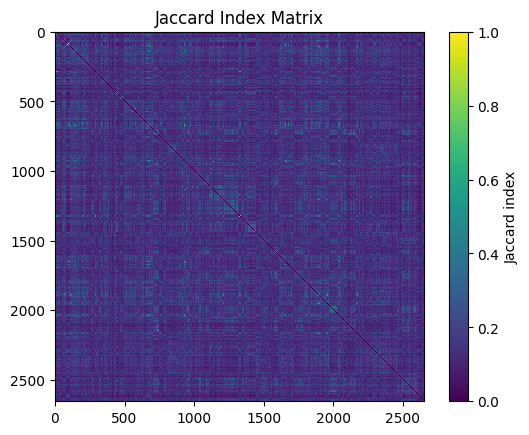

In [179]:
import matplotlib.pyplot as plt

plt.imshow(jaccard_matrix, interpolation="nearest", cmap="viridis")
plt.colorbar(label="Jaccard index")
plt.title("Jaccard Index Matrix")
plt.show()

In [187]:
J_TRESHOLD = 0.8

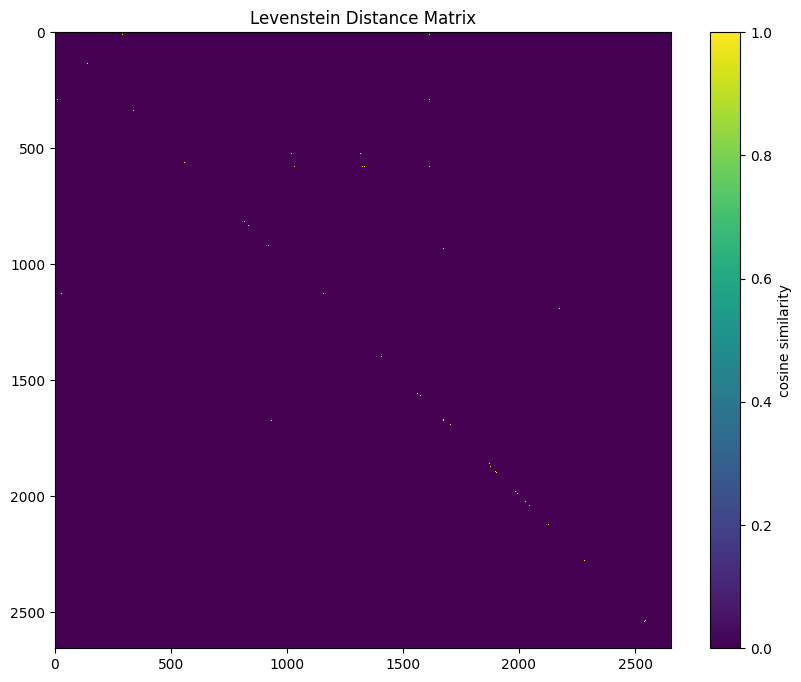

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(jaccard_matrix > J_TRESHOLD, interpolation="nearest", cmap="viridis")
plt.colorbar(label="cosine similarity")
plt.title("Levenstein Distance Matrix")
plt.show()

In [189]:
import numpy as np


def find_values_above_threshold(matrix, threshold, exclude_diagonal=True):
    rows, cols = np.where(matrix > threshold)
    results = [(r, c, matrix[r, c]) for r, c in zip(rows, cols)]
    
    if exclude_diagonal:
        results = [(r, c, val) for r, c, val in results if r != c]
    
    return results

find_values_above_threshold(jaccard_matrix, threshold=J_TRESHOLD)

[(np.int64(8), np.int64(9), np.float64(0.8333333333333334)),
 (np.int64(9), np.int64(8), np.float64(0.8333333333333334)),
 (np.int64(10), np.int64(290), np.float64(0.8846153846153846)),
 (np.int64(10), np.int64(1611), np.float64(0.8076923076923077)),
 (np.int64(14), np.int64(17), np.float64(0.9029126213592233)),
 (np.int64(17), np.int64(14), np.float64(0.9029126213592233)),
 (np.int64(18), np.int64(19), np.float64(0.9411764705882353)),
 (np.int64(18), np.int64(20), np.float64(0.927536231884058)),
 (np.int64(18), np.int64(21), np.float64(0.9142857142857143)),
 (np.int64(19), np.int64(18), np.float64(0.9411764705882353)),
 (np.int64(19), np.int64(20), np.float64(0.927536231884058)),
 (np.int64(19), np.int64(21), np.float64(0.9142857142857143)),
 (np.int64(20), np.int64(18), np.float64(0.927536231884058)),
 (np.int64(20), np.int64(19), np.float64(0.927536231884058)),
 (np.int64(20), np.int64(21), np.float64(0.9014084507042254)),
 (np.int64(21), np.int64(18), np.float64(0.9142857142857143)

In [192]:
print(code_mx.iloc[10]['wo_docstring_code'])

def fit_predict(self, X, y=None, **kwargs):
    self.fit(X, **kwargs)
    return self.labels_


In [193]:
print(code_mx.iloc[290]['wo_docstring_code'])

def fit_predict(self, X, y=None):
    self.fit(X)
    return self.labels_


# Structure graph (KG Building)

## Build folder structure graph

In [2]:
import os
import ast
import pandas as pd

def extract_classes_from_file(file_path):
    """Return a list of class names defined in a Python file."""
    with open(file_path, "r", encoding="utf-8") as f:
        tree = ast.parse(f.read(), filename=file_path)
    return [node.name for node in ast.walk(tree) if isinstance(node, ast.ClassDef)]

def build_structure_graph(root_folder):
    """Build a graph of folders, .py files, and class definitions with integer node IDs, including full_name."""
    graph_data = []
    node_id_counter = [0]
    path_to_id = {}

    def next_node_id():
        node_id = node_id_counter[0]
        node_id_counter[0] += 1
        return node_id

    def process_directory(current_path, parent_id=None):
        dir_name = os.path.basename(current_path.rstrip(os.sep))
        dir_node_id = next_node_id()
        path_to_id[current_path] = dir_node_id

        graph_data.append({
            "node_id": dir_node_id,
            "node_name": dir_name,
            "node_type": "folder",
            "node_parent_id": parent_id,
            "full_name": current_path
        })

        for entry in os.scandir(current_path):
            entry_path = entry.path
            if entry.is_file() and entry.name.endswith(".py") and entry.name != "__init__.py":
                file_node_id = next_node_id()
                graph_data.append({
                    "node_id": file_node_id,
                    "node_name": entry.name,
                    "node_type": "file",
                    "node_parent_id": dir_node_id,
                    "full_name": entry_path
                })

                class_names = extract_classes_from_file(entry_path)
                for class_name in class_names:
                    class_node_id = next_node_id()
                    graph_data.append({
                        "node_id": class_node_id,
                        "node_name": class_name,
                        "node_type": "class",
                        "node_parent_id": file_node_id,
                        "full_name": f"{entry_path}::{class_name}"
                    })

            elif entry.is_dir() and (not entry.name.startswith('.') or entry.name.startswith('_')):
                process_directory(entry_path, parent_id=dir_node_id)

    # Start processing
    process_directory(root_folder)

    nodes = pd.DataFrame(graph_data)
    edges = pd.DataFrame({
        "source": nodes["node_parent_id"],
        "target": nodes["node_id"],
    })
    edges = edges.dropna()
    edges['source'] = edges['source'].astype(int)
    edges['target'] = edges['target'].astype(int)

    return nodes, edges


In [3]:
# Example usage:
nodes, edges = build_structure_graph("repos/Python/manim/manim")
nodes['full_name'] = nodes['full_name'].apply(lambda x: x.replace('repos/Python/manim/', ''))
nodes

node_id      node_name node_type  node_parent_id  \
0          0          manim    folder             NaN   
1          1      animation    folder             0.0   
2          2   animation.py      file             1.0   
3          3      Animation     class             2.0   
4          4           Wait     class             2.0   
..       ...            ...       ...             ...   
526      526  JSONFormatter     class           525.0   
527      527       utils.py      file           523.0   
528      528    ManimConfig     class           527.0   
529      529     ManimFrame     class           527.0   
530      530    __main__.py      file             0.0   

                                        full_name  
0                                           manim  
1                                 manim\animation  
2                    manim\animation\animation.py  
3         manim\animation\animation.py::Animation  
4              manim\animation\animation.py::Wait  
..                                            ...  
526  manim\_config\logger_utils.py::JSONFormatter  
527                        manim\_config\utils.py  
528           manim\_config\utils.py::ManimConfig  
529            manim\_config\utils.py::ManimFrame  
530                             manim\__main__.py  

[531 rows x 5 columns]

In [4]:
nodes.to_csv('graph/manim/structure_nodes.csv', index=False)
edges.to_csv('graph/manim/structure_edges.csv', index=False)

In [4]:
# Create graph
G = nx.Graph()

# Add nodes
for _, row in nodes.iterrows():
    node_id = str(row['node_id'])
    node_label = str(row['node_name'])
    G.add_node(node_id, label=node_label)

# Add edges
for _, row in edges.iterrows():
    source = str(row['source'])
    target = str(row['target'])
    if source in G.nodes and target in G.nodes:
        G.add_edge(source, target)

# Pyvis graph
net = Network(height='900px', width='100%', notebook=False)
net.from_nx(G)
net.force_atlas_2based()

# Save
net.save_graph('test_graph.html')

In [6]:
nodes, edges = CallGraphBuilder().build_call_graph("repos/Python/scikit-learn/sklearn")

In [7]:
nodes

file_id fnc_id  \
0      9041255f-6a13-11f0-9787-581cf8fd201d      0   
1      9041255f-6a13-11f0-9787-581cf8fd201d      1   
2      9041255f-6a13-11f0-9787-581cf8fd201d      2   
3      9041255f-6a13-11f0-9787-581cf8fd201d      3   
4      9041255f-6a13-11f0-9787-581cf8fd201d      4   
...                                     ...    ...   
10347  d89d2799-6a15-11f0-a7f7-581cf8fd201d  10347   
10348  d89d2799-6a15-11f0-a7f7-581cf8fd201d  10348   
10349  d89d2799-6a15-11f0-a7f7-581cf8fd201d  10349   
10350  d89d2799-6a15-11f0-a7f7-581cf8fd201d  10350   
10351  dfa0c754-6a15-11f0-872f-581cf8fd201d  10351   

                                        name          class  \
0                                      clone         Global   
1                        _clone_parametrized         Global   
2                           _get_param_names  BaseEstimator   
3                                 get_params  BaseEstimator   
4                           _get_params_html  BaseEstimator   
...                                      ...            ...   
10347  test_init_gradient_and_hessian_raises         Global   
10348    test_loss_init_parameter_validation         Global   
10349                       test_loss_pickle         Global   
10350  test_tweedie_log_identity_consistency         Global   
10351                      raise_build_error         Global   

                                      class_base_classes  \
0                                                     []   
1                                                     []   
2      [ReprHTMLMixin, _HTMLDocumentationLinkMixin, _...   
3      [ReprHTMLMixin, _HTMLDocumentationLinkMixin, _...   
4      [ReprHTMLMixin, _HTMLDocumentationLinkMixin, _...   
...                                                  ...   
10347                                                 []   
10348                                                 []   
10349                                                 []   
10350                                                 []   
10351                                                 []   

                                                  params  \
0                                   {"estimator": "Any"}   
1                                   {"estimator": "Any"}   
2                                         {"cls": "Any"}   
3                         {"self": "Any", "deep": "Any"}   
4                         {"self": "Any", "deep": "Any"}   
...                                                  ...   
10347  {"loss": "Any", "params": "Any", "err_msg": "A...   
10348  {"loss": "Any", "params": "Any", "err_type": "...   
10349                                    {"loss": "Any"}   
10350                                       {"p": "Any"}   
10351                                       {"e": "Any"}   

                                               docstring  \
0      Construct a new unfitted estimator with the sa...   
1      Default implementation of clone. See :func:`sk...   
2                  Get parameter names for the estimator   
3      Get parameters for this estimator.\n\nParamete...   
4      Get parameters for this estimator with a speci...   
...                                                  ...   
10347  Test that init_gradient_and_hessian raises err...   
10348    Test that loss raises errors for invalid input.   
10349                   Test that losses can be pickled.   
10350  Test for identical losses when only the link f...   
10351                                               None   

                                           function_code class_id  \
0      def clone(estimator, *, safe=True):\n    """Co...     None   
1      def _clone_parametrized(estimator, *, safe=Tru...     None   
2      @classmethod\ndef _get_param_names(cls):\n    ...        0   
3      def get_params(self, deep=True):\n    """\n   ...        0   
4      def _get_params_html(self, deep=True):\n    ""...        0   
...                                                  

In [8]:
nodes.to_csv('graph/sklearn/cg_nodes_QNA.csv', index=False)
edges.to_csv('graph/sklearn/cg_edges_QNA.csv', index=False)